In [4]:

import numpy as np
import cv2
from scipy.spatial import distance
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import label
from skimage.measure import regionprops
from scipy.signal import find_peaks, butter, filtfilt
from scipy.ndimage import gaussian_filter
import pywt
import os
import logging
import pandas as pd
import time
from PIL import Image
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.stats import skew, kurtosis

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Hybrid Approach for Nucleus Segmentation and Fluorescent Point Detection

def hybrid_detect_fluorescent_points(image, manual_threshold_value=0.1):
    logging.info("Starting hybrid fluorescent point detection")

    # Step 1: Normalize the image (from Approach 1)
    image_norm = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    # Step 2: Attempt Otsu's thresholding (from Approach 2)
    try:
        otsu_thresh_val = threshold_otsu(image_norm)
        binary_otsu = image_norm > otsu_thresh_val
        logging.info("Otsu's thresholding applied successfully")

    except Exception as e:
        logging.warning(f"Otsu's thresholding failed: {e}")
        binary_otsu = None

    # Step 3: Manual thresholding (from Approach 1) as fallback or secondary step
    _, binary_manual = cv2.threshold(image_norm, manual_threshold_value, 1, cv2.THRESH_BINARY)

    # Step 4: Combine results if both methods were successful
    if binary_otsu is not None:
        binary_combined = np.logical_or(binary_otsu, binary_manual)
    else:
        binary_combined = binary_manual  # If Otsu failed, use manual threshold only

    # Step 5: Post-processing (clear border and label connected components)
    cleared = clear_border(binary_combined)
    label_image = label(cleared)

    logging.info("Completed hybrid fluorescent point detection")
    return label_image

# Function to load and process TIFF data in batches
def load_and_preprocess_tiff_in_batches(file_path, batch_size=10):
    logging.info(f"Checking file: {file_path}")
    if os.path.exists(file_path):
        try:
            tiff_image = Image.open(file_path)
            frames = []
            batch_results = []

            for i in range(tiff_image.n_frames):
                tiff_image.seek(i)
                frame = np.array(tiff_image)
                frames.append(frame)
                
                # Process in batches
                if len(frames) == batch_size:
                    batch_result = process_batch(np.stack(frames, axis=0))
                    batch_results.append(batch_result)
                    frames = []  # Clear memory after processing each batch

            # Process any remaining frames
            if frames:
                batch_result = process_batch(np.stack(frames, axis=0))
                batch_results.append(batch_result)
                
            tiff_image.close()

            logging.info(f"Successfully processed {len(batch_results)} batches from {file_path}")
            return np.concatenate(batch_results, axis=0)

        except Exception as e:
            logging.error(f"Error loading TIFF data from {file_path}: {e}")
            return None
    else:
        logging.error(f'TIFF file not found: {file_path}')
        return None

def process_batch(frames):
    # Perform motion correction on the batch of frames
    corrected_frames = motion_correction(frames)
    return corrected_frames

# Function to perform motion correction on 3D data with parallel processing
def motion_correction(frames):
    logging.info("Starting motion correction")
    ref_frame = frames[0].astype(np.float32)
    
    def correct_frame(frame):
        frame = frame.astype(np.float32)
        res = cv2.matchTemplate(frame, ref_frame, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(res)
        corrected_frame = np.roll(frame, -max_loc[0], axis=1)
        corrected_frame = np.roll(corrected_frame, -max_loc[1], axis=0)
        return corrected_frame
    
    with ThreadPoolExecutor() as executor:
        corrected_frames = list(executor.map(correct_frame, frames))
    
    logging.info("Completed motion correction")
    return np.stack(corrected_frames, axis=0)

# Function to extract fluorescent intensities for detected points
def extract_fluorescent_intensities(label_image, frames):
    logging.info("Starting extraction of fluorescent intensities")
    intensities = {}
    for region in measure.regionprops(label_image):
        coords = region.coords
        neuron_id = region.label
        neuron_intensity = []

        if coords.shape[1] == 3:  # Handling 3D coordinates
            for frame in frames:
                neuron_intensity.append(np.mean([frame[z, y, x] for z, y, x in coords]))
        elif coords.shape[1] == 2:  # Handling 2D coordinates (Z assumed to be absent)
            for frame in frames:
                neuron_intensity.append(np.mean([frame[y, x] for y, x in coords]))

        intensities[neuron_id] = neuron_intensity
    logging.info("Completed extraction of fluorescent intensities")
    return intensities

# Function to match neurons based on 3D centroids
def match_neurons(control_fluorescent_label_image, treated_fluorescent_label_image):
    logging.info("Starting neuron matching based on 3D centroids")
    control_centroids = np.array([np.mean(region.coords, axis=0) for region in measure.regionprops(control_fluorescent_label_image)])
    treated_centroids = np.array([np.mean(region.coords, axis=0) for region in measure.regionprops(treated_fluorescent_label_image)])
    
    matched_indices = []
    for control_index, control_centroid in enumerate(control_centroids):
        distances = distance.cdist([control_centroid], treated_centroids, 'euclidean')
        matched_index = np.argmin(distances)
        
        # Check if both control and treated indices exist
        if control_index in control_fluorescent_label_image and matched_index in treated_fluorescent_label_image:
            matched_indices.append((control_index, matched_index))
    
    logging.info("Completed neuron matching")
    return matched_indices

# Function to visualize calcium dynamics in 3D
def visualize_calcium_3d(intensities, time_points, output_path, neuron_id, group_label):
    logging.info(f"Starting 3D visualization for neuron {neuron_id} in {group_label}")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(time_points, intensities, zs=neuron_id, zdir='y', label=f'Neuron {neuron_id}')
    ax.set_title(f'Calcium Dynamics for Neuron {neuron_id} ({group_label})')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron ID')
    ax.set_zlabel('Intensity')
    plt.legend()
    plt.savefig(output_path)
    plt.close()
    logging.info(f"Saved 3D visualization to {output_path}")


# Function to generate a time-lapse video
def generate_time_lapse_video(frames, output_path, fps=16.67):
    logging.info(f"Starting time-lapse video generation for {output_path}")
    if len(frames[0].shape) == 2:  # 2D frames (grayscale)
        height, width = frames[0].shape
        is_color = False
    elif len(frames[0].shape) == 3:  # 3D frames (assuming last dimension is color channel)
        height, width = frames[0].shape[1], frames[0].shape[2]
        is_color = True
    else:
        raise ValueError("Unexpected frame dimensions")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        if is_color:
            if frame.dtype != np.uint8:
                frame = cv2.convertScaleAbs(frame)
            video.write(frame)
        else:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            if frame_rgb.dtype != np.uint8:
                frame_rgb = cv2.convertScaleAbs(frame_rgb)
            video.write(frame_rgb)

    video.release()
    logging.info(f"Completed time-lapse video generation for {output_path}")

# Function to calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(signal, noise):
    logging.info("Calculating SNR")
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate Root Mean Square Error (RMSE)
def calculate_rmse(predicted, actual):
    logging.info("Calculating RMSE")
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    return rmse

# ALS baseline correction function
def baseline_als(y, lam=1e6, p=0.01, niter=10):
    logging.info("Starting ALS baseline correction")
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    W = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(W, 0, L, L)
        Z = spsolve(W + lam * D.dot(D.T), W * y)
        W = p * (y > Z) + (1 - p) * (y < Z)
    logging.info("Completed ALS baseline correction")
    return Z

# Preprocessing function using different filters
def preprocess_signal(signal):
    logging.info("Starting signal preprocessing")
    # ALS Baseline Correction
    baseline = baseline_als(signal)
    detrended_signal = signal - baseline

    # Gaussian Filter
    gaussian_filtered = gaussian_filter(detrended_signal, sigma=1)
    
    logging.info("Completed signal preprocessing")
    return gaussian_filtered

# Function to calculate calcium transients
def calculate_calcium_transients(intensities):
    logging.info("Starting calcium transient calculations")
    transients = {}
    snr_values = {}
    rmse_values = {}
    for neuron_id, intensity in intensities.items():
        intensity = np.array(intensity)
        if len(intensity) == 0:
            logging.warning(f"No data available for neuron {neuron_id}")
            continue
        filtered_signal = preprocess_signal(intensity)

        transients[neuron_id] = {}
        snr_values[neuron_id] = {}
        rmse_values[neuron_id] = {}

        smoothed_intensity = filtered_signal[:400]  # Focus on frames 0 to 400

        # Calculate the baseline and standard deviation
        baseline_mean = np.mean(smoothed_intensity)
        baseline_std = np.std(smoothed_intensity)

        # Set the peak threshold as a multiple of the standard deviation
        peak_threshold = baseline_mean + 2 * baseline_std

        peaks, _ = find_peaks(smoothed_intensity, height=peak_threshold)
        if len(peaks) == 0:
            logging.warning(f"No peaks detected for neuron {neuron_id}")
            continue

        amplitudes = smoothed_intensity[peaks] - baseline_mean
        durations = np.diff(peaks) if len(peaks) > 1 else np.array([np.nan])
        frequency = len(peaks) / (len(intensity) / 16.67)  # Using fps of 16.67
        rise_times = []
        decay_times = []

        for peak in peaks:
            baseline = np.mean(smoothed_intensity[:peak])
            rise_indices = np.where(smoothed_intensity[:peak] <= baseline)[0]
            if len(rise_indices) > 0:
                rise_start = rise_indices[-1]
            else:
                rise_start = 0
            rise_time = peak - rise_start
            rise_times.append(rise_time)

            decay_indices = np.where(smoothed_intensity[peak:] <= baseline + (baseline_std * 0.5))[0]
            if len(decay_indices) > 0:
                decay_end = decay_indices[0] + peak
                decay_time = decay_end - peak
            else:
                decay_time = len(smoothed_intensity) - peak
            decay_times.append(decay_time)

        transients[neuron_id]['ALS_Gaussian'] = {
            'Amplitude': amplitudes,
            'Frequency': frequency,
            'Duration': durations,
            'Rise Time': rise_times if len(rise_times) > 0 else np.nan,
            'Decay Time': decay_times if len(decay_times) > 0 else np.nan,
            'Smoothed Intensity': smoothed_intensity,
            'Skewness': skew(smoothed_intensity),
            'Kurtosis': kurtosis(smoothed_intensity),
            'Integrated Intensity': np.sum(smoothed_intensity)
        }

        # Calculate SNR and RMSE
        noise = smoothed_intensity - baseline_mean
        snr_values[neuron_id]['ALS_Gaussian'] = calculate_snr(smoothed_intensity, noise)
        rmse_values[neuron_id]['ALS_Gaussian'] = calculate_rmse(smoothed_intensity, intensity[:400])

    logging.info("Completed calcium transient calculations")
    return transients, snr_values, rmse_values



def visualize_calcium_transient_features(control_features, treated_features, title_suffix, output_dir, group_labels):
    logging.info(f"Visualizing calcium transient features for {title_suffix}")
    
    features = ['amplitude', 'mean_intensity', 'std_intensity', 'skewness', 'kurtosis', 'integrated_intensity']
    
    for feature in features:
        plt.figure(figsize=(10, 5))
        plt.bar(control_features.index, control_features[feature], alpha=0.7, label=f'{group_labels["control"]} - Control', color='blue')
        plt.bar(treated_features.index, treated_features[feature], alpha=0.7, label=f'{group_labels["treated"]} - Treated', color='red')
        plt.title(f'{feature.title()} Comparison - {title_suffix}')
        plt.xlabel('Neuron ID')
        plt.ylabel(feature.title())
        plt.legend()
        plt_path = os.path.join(output_dir, f'{feature}_{title_suffix}.png')
        plt.savefig(plt_path)
        plt.close()
        logging.info(f"Saved {feature} visualization to {plt_path}")


# Function to analyze calcium transients with additional features
def analyze_calcium_transients(df):
    """
    Analyzes calcium transients in the given DataFrame.
    Args:
    - df: A DataFrame where each column represents the signal for a neuron over time.

    Returns:
    - A DataFrame containing features such as amplitude, rise time, decay time, etc., for each neuron.
    """
    logging.info("Starting analysis of calcium transients")
    
    features = pd.DataFrame(index=df.columns)
    
    features['amplitude'] = df.max() - df.min()
    features['mean_intensity'] = df.mean()
    features['std_intensity'] = df.std()
    features['skewness'] = df.apply(skew, axis=0)
    features['kurtosis'] = df.apply(kurtosis, axis=0)
    features['integrated_intensity'] = df.sum()
    
    # More complex features can be added here as needed
    logging.info("Completed analysis of calcium transients")
    
    return features

# Function to summarize analysis results
def summarize_analysis(transients):
    logging.info("Starting analysis summary")
    summary = {
        'Total Neurons': len(transients),
        'Neurons with Complete Data': 0,
        'Neurons with Missing Decay Times': 0
    }
    for neuron_id, data in transients.items():
        decay_times = data['ALS_Gaussian']['Decay Time']
        if np.isnan(decay_times).any():
            summary['Neurons with Missing Decay Times'] += 1
        else:
            summary['Neurons with Complete Data'] += 1
    
    print("Analysis Summary:")
    print(f"Total Neurons Analyzed: {summary['Total Neurons']}")
    print(f"Neurons with Complete Data: {summary['Neurons with Complete Data']}")
    print(f"Neurons with Missing Decay Times: {summary['Neurons with Missing Decay Times']}")

    logging.info("Completed analysis summary")
    return summary

# Function to plot calcium transients metrics for all neurons
def plot_all_metrics(transients, group_label):
    logging.info("Starting plotting of all metrics")
    metrics = ['Amplitude', 'Frequency', 'Duration', 'Rise Time', 'Decay Time', 'Skewness', 'Kurtosis', 'Integrated Intensity']
    
    for metric in metrics:
        values = [np.mean(data['ALS_Gaussian'][metric]) for _, data in transients.items() if metric in data['ALS_Gaussian']]
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(values)), values)
        plt.title(f'Mean {metric} for All Neurons ({group_label})')
        plt.xlabel('Neuron ID')
        plt.ylabel(metric)
        plt.show()
    logging.info("Completed plotting of all metrics")

    
    
#  Function to summarize analysis results and generate a detailed comparison between control and treated groups    
def generate_summary(control_features, treated_features, time_point, dose_type):
    summary = f"Summary for {time_point} - {dose_type} Dose\n"
    summary += "----------------------------------------\n"
    summary += f"Number of neurons analyzed in control: {len(control_features)}\n"
    summary += f"Number of neurons analyzed in treated: {len(treated_features)}\n\n"
    
    metrics = ['amplitude', 'frequency', 'integrated_intensity', 'decay_time', 'rise_time', 'duration']
    
    for metric in metrics:
        if metric in control_features.columns and metric in treated_features.columns:
            control_mean = control_features[metric].mean()
            treated_mean = treated_features[metric].mean()
            control_std = control_features[metric].std()
            treated_std = treated_features[metric].std()

            summary += f"Metric: {metric.replace('_', ' ').title()}\n"
            summary += f"Control Mean: {control_mean:.2f} ± {control_std:.2f}\n"
            summary += f"Treated Mean: {treated_mean:.2f} ± {treated_std:.2f}\n"
            summary += f"Difference (Treated - Control): {treated_mean - control_mean:.2f}\n"
            summary += "----------------------------------------\n"
        else:
            summary += f"Metric: {metric.replace('_', ' ').title()}\n"
            summary += "Data not available for comparison\n"
            summary += "----------------------------------------\n"

    return summary
    

# Updated `main` function to integrate new features with lazy loading and batch processing

def main():
    logging.info("Starting main processing loop")
    base_dir = r"D:\Kofi-TH2\TIF data for final analysis"
    control_paths = {
        '3dpf': os.path.join(base_dir, 'control', '3dpf_control_larvae-14.tif'),
        '4dpf': os.path.join(base_dir, 'control', '4dpf_control.tif'),
        '7dpf': os.path.join(base_dir, 'control', '7dpf_control.tif'),
        '10dpf': os.path.join(base_dir, 'control', '10dpf_control_larvae-14.tif'),
        '14dpf': os.path.join(base_dir, 'control', '14dpf_control_larvae-14.tif')
    }

    treated_paths = {
        'single_3dpf': os.path.join(base_dir, 'single', '3dpf_double_dose_1hr_post_treatment.tif'),
        'single_10dpf': os.path.join(base_dir, 'single', '10dpf_singledose_treatment.tif'),
        'single_14dpf': os.path.join(base_dir, 'single', '14dpf_singledose_treatment.tif'),
        'double_4dpf': os.path.join(base_dir, 'double', '4dpf_double_dose_1hr_post_treatment.tif'),
        'double_10dpf': os.path.join(base_dir, 'double', '10dpf_double_dose_treatment.tif'),
        'double_14dpf': os.path.join(base_dir, 'double', '14dpf_double_dose_treatment.tif'),
        'triple_7dpf': os.path.join(base_dir, 'triple', '7dpf_triple_dose_1hr_post_treatment.tif'),
        'triple_10dpf': os.path.join(base_dir, 'triple', '10dpf_triple_dose_treatment.tif'),
        'triple_14dpf': os.path.join(base_dir, 'triple', '14dpf_triple_dose_treatment.tif')
    }

    output_dir = r"D:\Kofi-TH2\working code output data"
    os.makedirs(output_dir, exist_ok=True)

    results = {}

    for time_point, control_path in control_paths.items():
        logging.info(f"Processing control data for {time_point}")
        control_frames = load_and_preprocess_tiff_in_batches(control_path)
        if control_frames is not None:
            logging.info(f'Loaded control TIFF data for {time_point}: {control_frames.shape[0]} frames')

            # Perform motion correction on the control frames
            control_frames = motion_correction(control_frames)
            control_fluorescent_label_image = hybrid_detect_fluorescent_points(control_frames[0])
            control_intensities = extract_fluorescent_intensities(control_fluorescent_label_image, control_frames)

            # Preprocess signals (if applicable)
            for neuron_id, signal in control_intensities.items():
                control_intensities[neuron_id] = preprocess_signal(np.array(signal))
                
            # Analyze the control data to obtain control_features 
            control_features = analyze_calcium_transients(pd.DataFrame(control_intensities).T)   

            # Define treated_keys based on the time point
            treated_keys = [time_point]
            if time_point in ['7dpf', '10dpf', '14dpf']:
                treated_keys = [f'single_{time_point}', f'double_{time_point}', f'triple_{time_point}']

            for treated_key in treated_keys:
                logging.info(f"Processing treated data for {treated_key}")
                treated_path = treated_paths.get(treated_key)
                if treated_path and os.path.exists(treated_path):
                    treated_frames = load_and_preprocess_tiff_in_batches(treated_path)
                    if treated_frames is not None:
                        logging.info(f'Loaded treated TIFF data for {treated_key}: {treated_frames.shape[0]} frames')

                        treated_fluorescent_label_image = hybrid_detect_fluorescent_points(treated_frames[0])
                        treated_intensities = extract_fluorescent_intensities(treated_fluorescent_label_image, treated_frames)
                        matched_indices = match_neurons(control_fluorescent_label_image, treated_fluorescent_label_image)

                        for control_id, treated_id in matched_indices:
                            if treated_id in treated_intensities:
                                time_points = np.arange(0, len(treated_frames)) * (1000 / 16.67)
                                output_path = os.path.join(output_dir, f'3d_visualization_{treated_key}_neuron_{treated_id}.png')
                                visualize_calcium_3d(treated_intensities[treated_id], time_points, output_path, treated_id, group_label=treated_key)

                        # Calculate and analyze calcium transients
                        transients, snr_values, rmse_values = calculate_calcium_transients(treated_intensities)

                        # Summarize analysis
                        summarize_analysis(transients)

                        # Plot metrics for all neurons
                        plot_all_metrics(transients, group_label=treated_key)

                        # Visualize and summarize the calcium transient features
                        treated_features = analyze_calcium_transients(pd.DataFrame(treated_intensities).T)
                        title_suffix = f'{time_point} ({treated_key.split("_")[0].title()} Dose)'
                        group_labels = {"control": f'{time_point} Control', "treated": treated_key.split("_")[0].title()}
                        visualize_calcium_transient_features(control_features, treated_features, title_suffix, output_dir, group_labels)
                        summary_text = generate_summary(control_features, treated_features, time_point, treated_key.split("_")[0].title())
                        with open(os.path.join(output_dir, f'summary_{treated_key}.txt'), 'w') as summary_file:
                            summary_file.write(summary_text)

    logging.info("Completed main processing loop")


if __name__ == "__main__":
    main()

2024-08-17 19:04:46,911 - INFO - Starting main processing loop
2024-08-17 19:04:46,911 - INFO - Processing control data for 3dpf
2024-08-17 19:04:46,911 - INFO - Checking file: D:\Kofi-TH2\TIF data for final analysis\control\3dpf_control_larvae-14.tif
2024-08-17 19:04:46,911 - ERROR - TIFF file not found: D:\Kofi-TH2\TIF data for final analysis\control\3dpf_control_larvae-14.tif
2024-08-17 19:04:46,911 - INFO - Processing control data for 4dpf
2024-08-17 19:04:46,911 - INFO - Checking file: D:\Kofi-TH2\TIF data for final analysis\control\4dpf_control.tif
2024-08-17 19:04:50,087 - INFO - Starting motion correction
2024-08-17 19:04:50,400 - INFO - Completed motion correction
2024-08-17 19:04:50,822 - INFO - Starting motion correction
2024-08-17 19:04:51,141 - INFO - Completed motion correction
2024-08-17 19:04:51,555 - INFO - Starting motion correction
2024-08-17 19:04:51,858 - INFO - Completed motion correction
2024-08-17 19:04:52,341 - INFO - Starting motion correction
2024-08-17 19:04

2024-08-17 18:19:19,913 - INFO - Starting main processing loop
2024-08-17 18:19:19,914 - INFO - Processing control data for 3dpf
2024-08-17 18:19:19,914 - INFO - Checking file: D:\Kofi-TH2\TIF data for final analysis\control\3dpf_baseline_control_larvae-14.tif
2024-08-17 18:19:20,046 - INFO - Starting motion correction
2024-08-17 18:19:20,380 - INFO - Completed motion correction
2024-08-17 18:19:20,513 - INFO - Starting motion correction
2024-08-17 18:19:20,823 - INFO - Completed motion correction
2024-08-17 18:19:20,940 - INFO - Starting motion correction
2024-08-17 18:19:21,248 - INFO - Completed motion correction
2024-08-17 18:19:21,363 - INFO - Starting motion correction
2024-08-17 18:19:21,694 - INFO - Completed motion correction
2024-08-17 18:19:21,812 - INFO - Starting motion correction
2024-08-17 18:19:22,136 - INFO - Completed motion correction
2024-08-17 18:19:22,270 - INFO - Starting motion correction
2024-08-17 18:19:22,576 - INFO - Completed motion correction
2024-08-17 18

Analysis Summary:
Total Neurons Analyzed: 63
Neurons with Complete Data: 63
Neurons with Missing Decay Times: 0


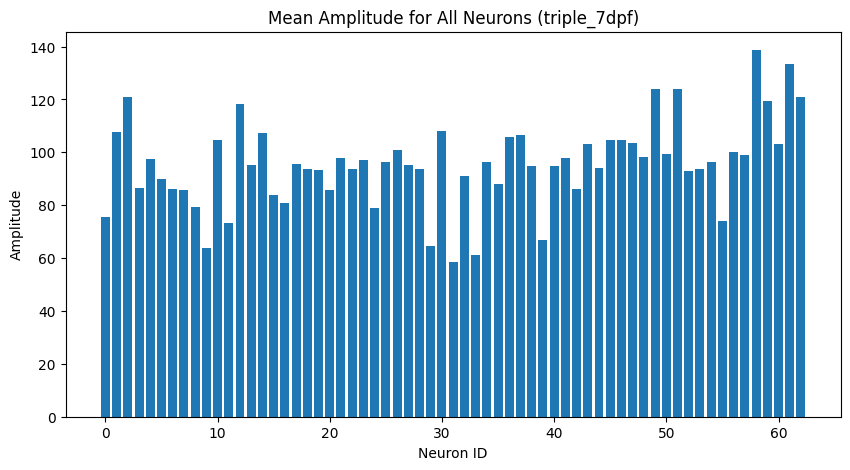

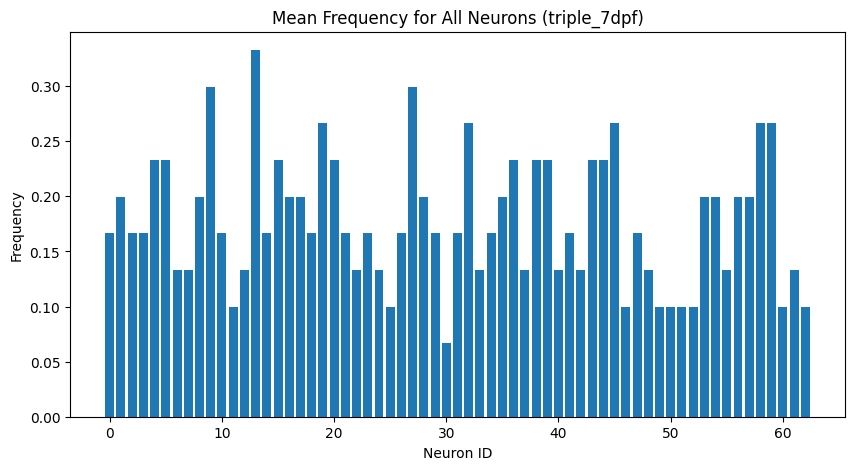

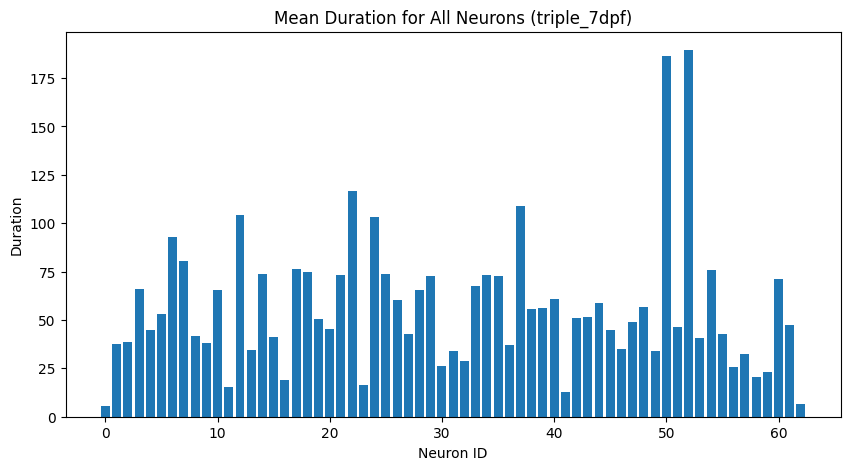

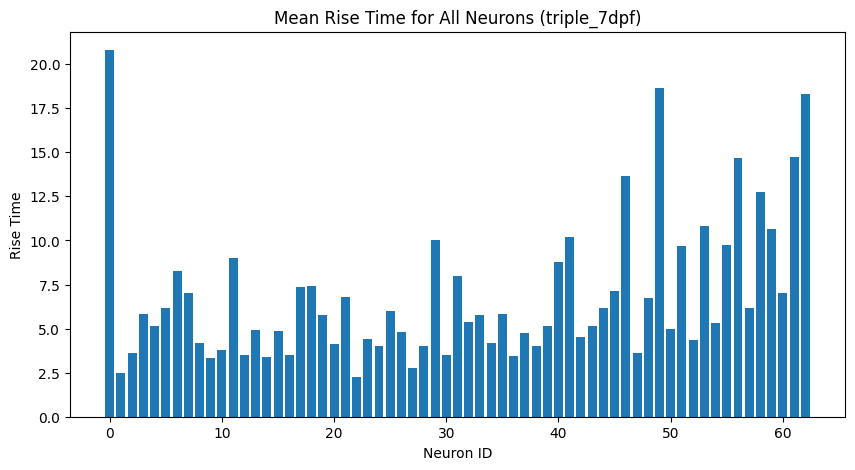

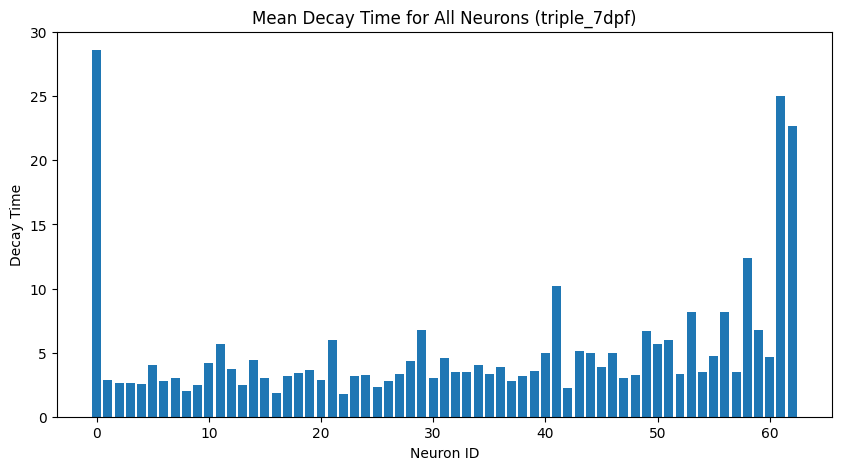

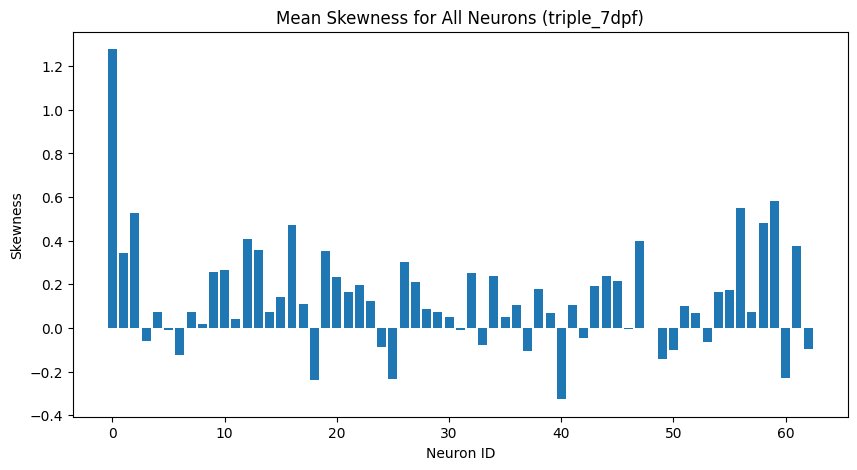

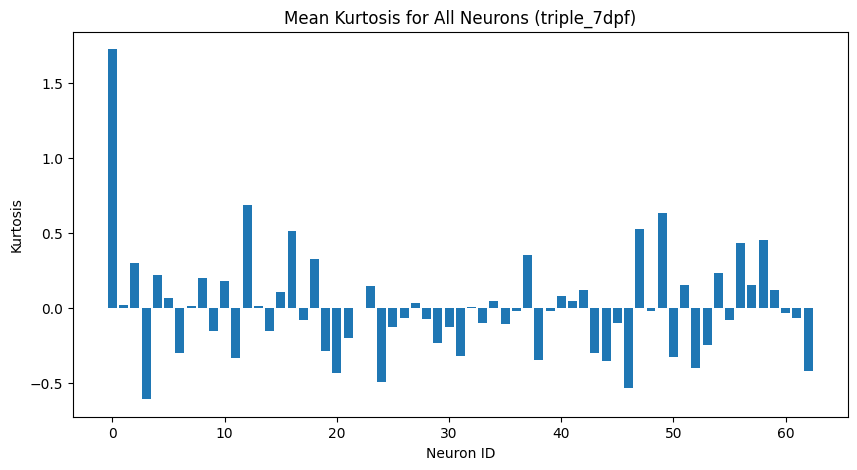

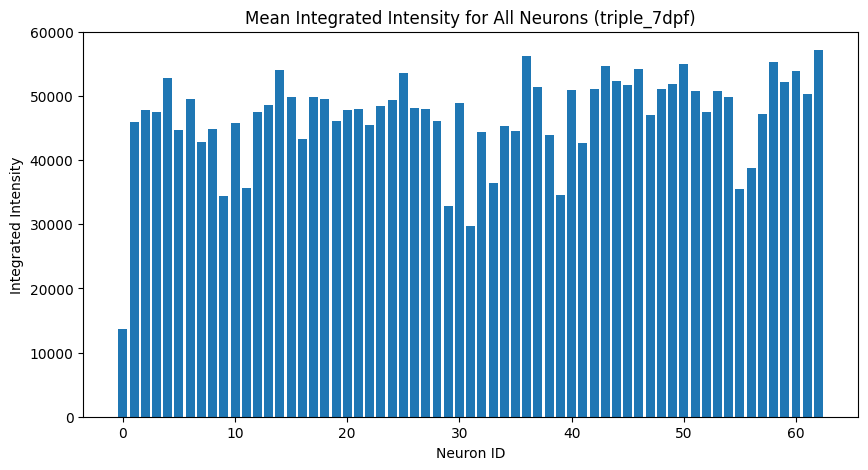

2024-08-17 18:23:23,642 - INFO - Completed plotting of all metrics
2024-08-17 18:23:23,642 - INFO - Starting analysis of calcium transients
2024-08-17 18:23:23,883 - INFO - Completed analysis of calcium transients
2024-08-17 18:23:23,884 - INFO - Visualizing calcium transient features for 7dpf (Triple Dose)
2024-08-17 18:23:24,542 - INFO - Saved amplitude visualization to D:\Kofi-TH2\working code output data\amplitude_7dpf (Triple Dose).png
2024-08-17 18:23:25,287 - INFO - Saved mean_intensity visualization to D:\Kofi-TH2\working code output data\mean_intensity_7dpf (Triple Dose).png
2024-08-17 18:23:26,008 - INFO - Saved std_intensity visualization to D:\Kofi-TH2\working code output data\std_intensity_7dpf (Triple Dose).png
2024-08-17 18:23:26,708 - INFO - Saved skewness visualization to D:\Kofi-TH2\working code output data\skewness_7dpf (Triple Dose).png
2024-08-17 18:23:27,361 - INFO - Saved kurtosis visualization to D:\Kofi-TH2\working code output data\kurtosis_7dpf (Triple Dose).p

Analysis Summary:
Total Neurons Analyzed: 39
Neurons with Complete Data: 39
Neurons with Missing Decay Times: 0


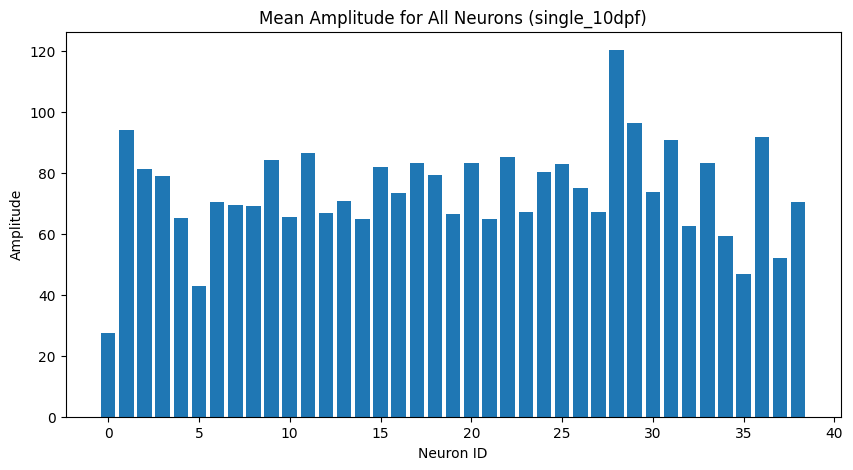

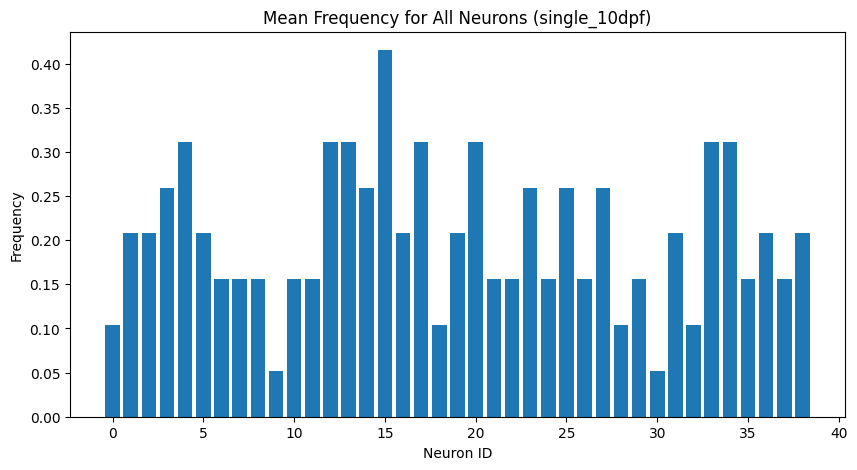

d:\anaconda3\envs\TH2_calcium_dynamics_analysis\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda3\envs\TH2_calcium_dynamics_analysis\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


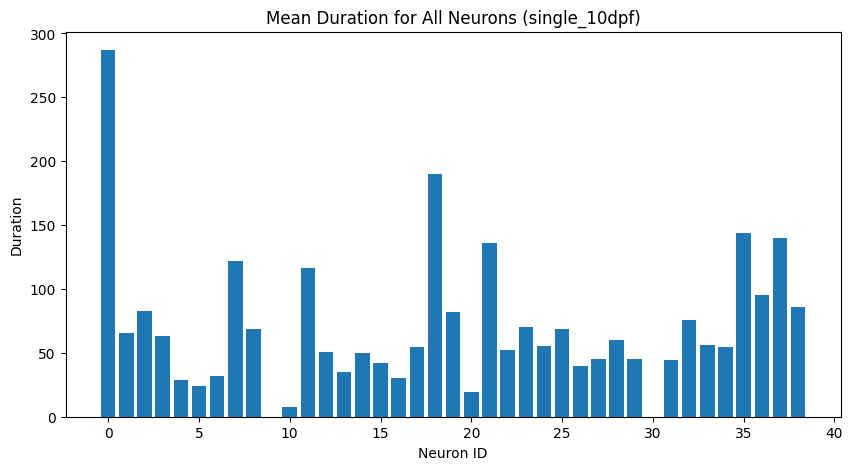

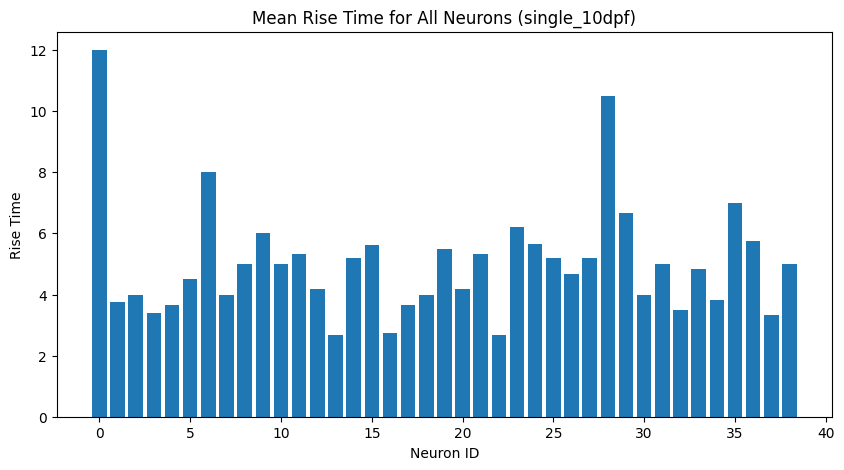

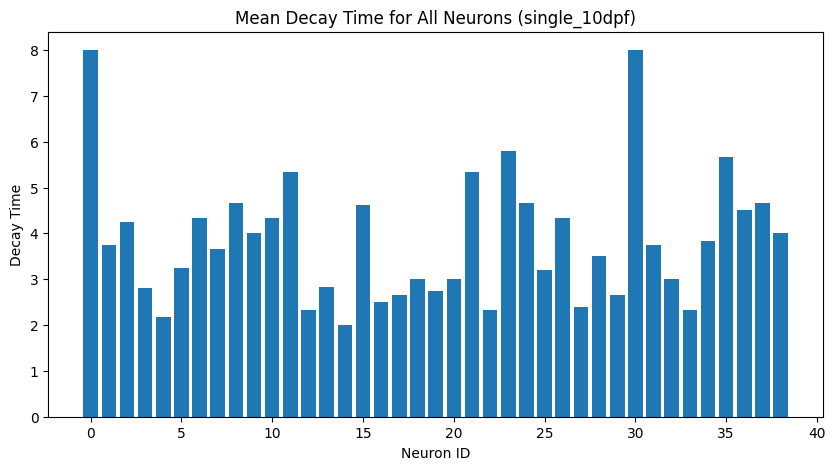

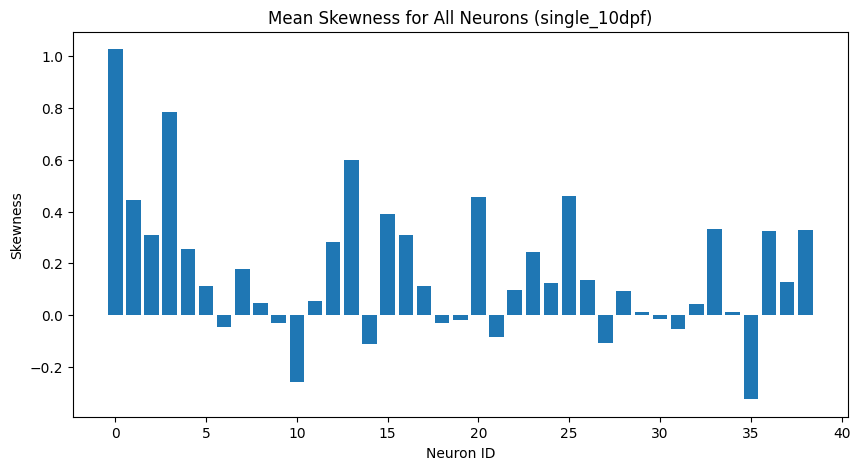

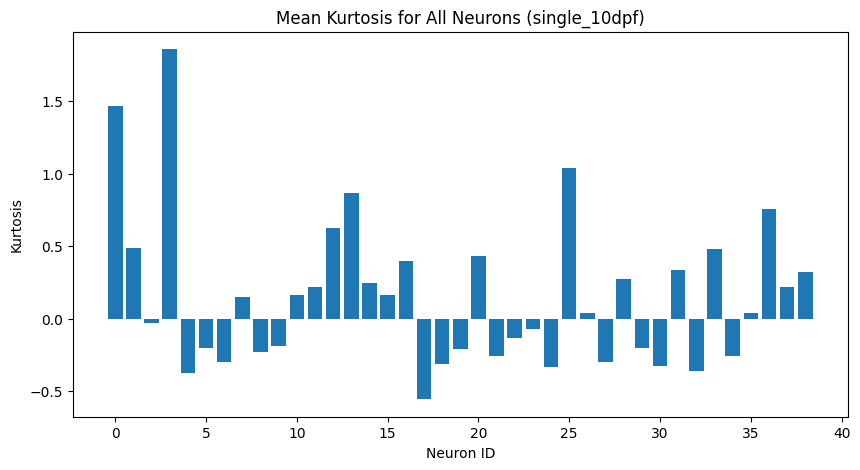

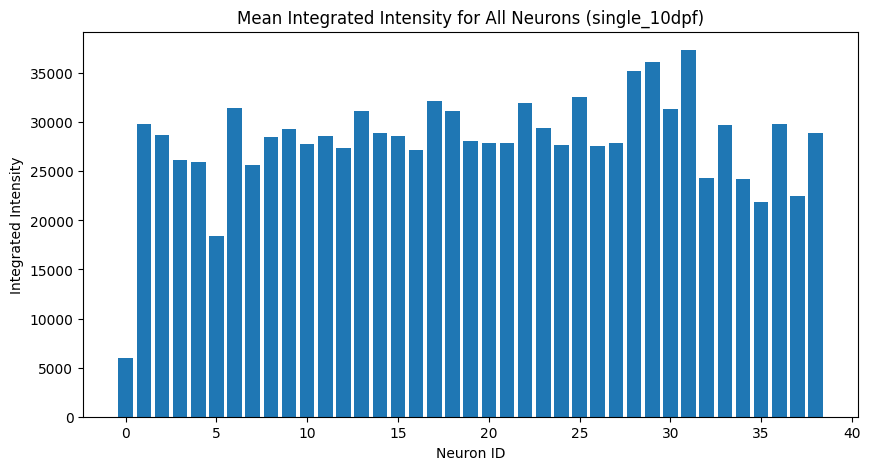

2024-08-17 18:25:27,389 - INFO - Completed plotting of all metrics
2024-08-17 18:25:27,390 - INFO - Starting analysis of calcium transients
2024-08-17 18:25:27,539 - INFO - Completed analysis of calcium transients
2024-08-17 18:25:27,539 - INFO - Visualizing calcium transient features for 10dpf (Single Dose)
2024-08-17 18:25:28,106 - INFO - Saved amplitude visualization to D:\Kofi-TH2\working code output data\amplitude_10dpf (Single Dose).png
2024-08-17 18:25:28,823 - INFO - Saved mean_intensity visualization to D:\Kofi-TH2\working code output data\mean_intensity_10dpf (Single Dose).png
2024-08-17 18:25:29,431 - INFO - Saved std_intensity visualization to D:\Kofi-TH2\working code output data\std_intensity_10dpf (Single Dose).png
2024-08-17 18:25:29,989 - INFO - Saved skewness visualization to D:\Kofi-TH2\working code output data\skewness_10dpf (Single Dose).png
2024-08-17 18:25:30,614 - INFO - Saved kurtosis visualization to D:\Kofi-TH2\working code output data\kurtosis_10dpf (Single D

Analysis Summary:
Total Neurons Analyzed: 46
Neurons with Complete Data: 46
Neurons with Missing Decay Times: 0


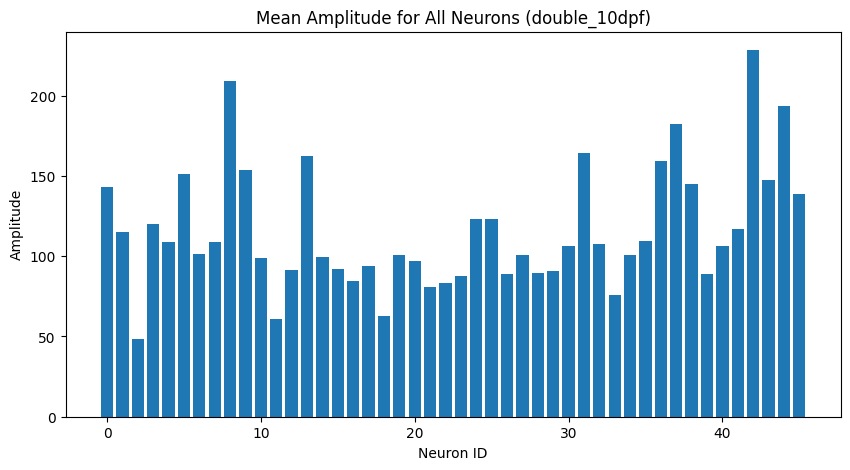

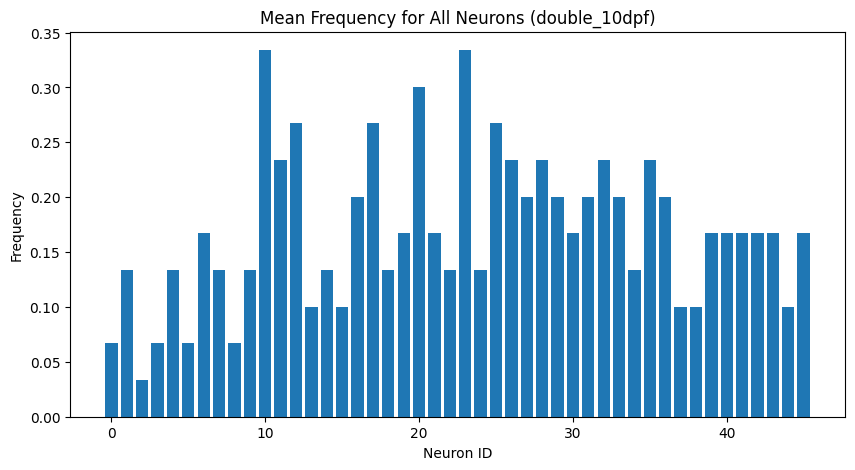

d:\anaconda3\envs\TH2_calcium_dynamics_analysis\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda3\envs\TH2_calcium_dynamics_analysis\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


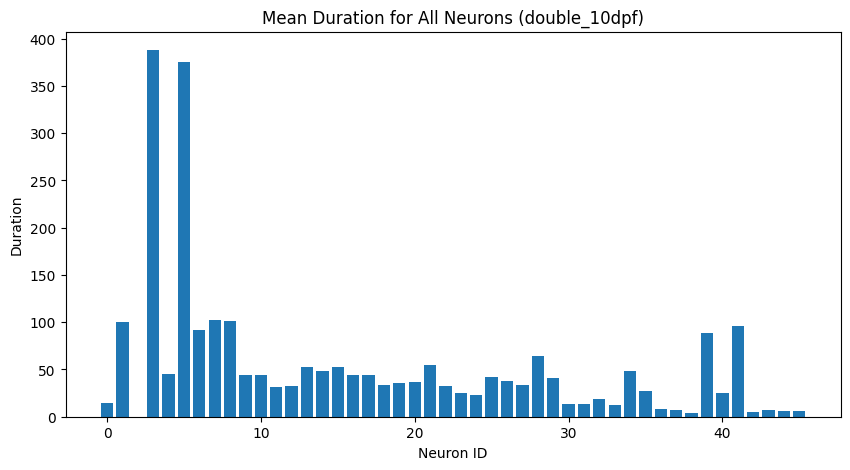

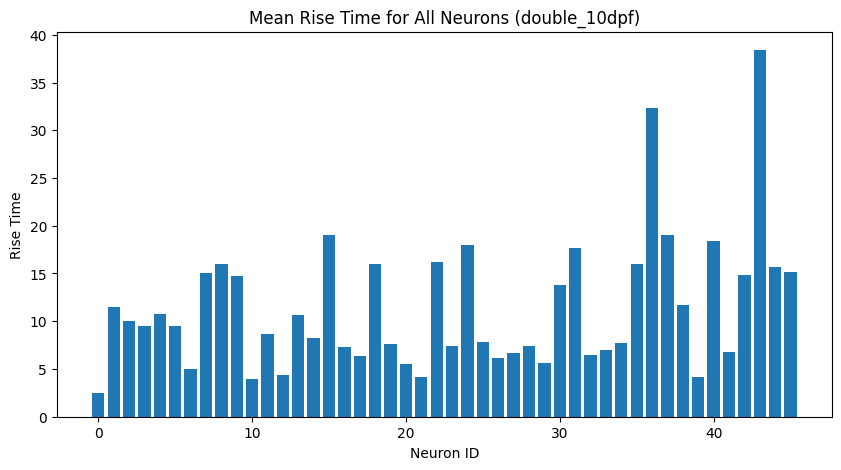

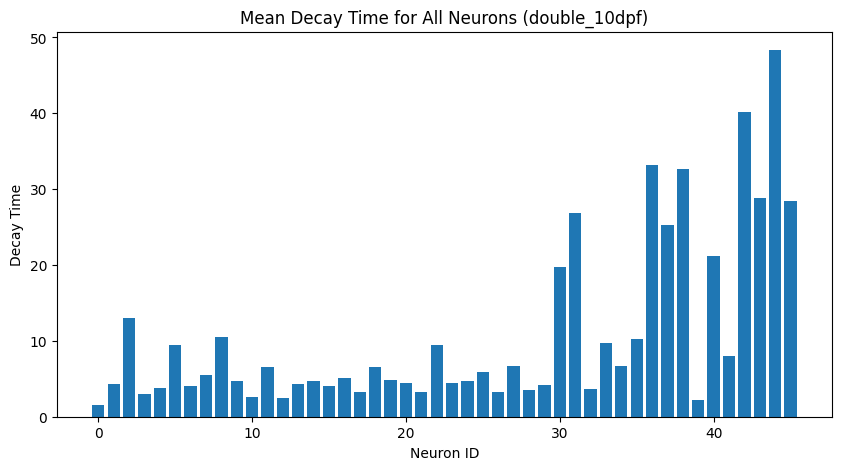

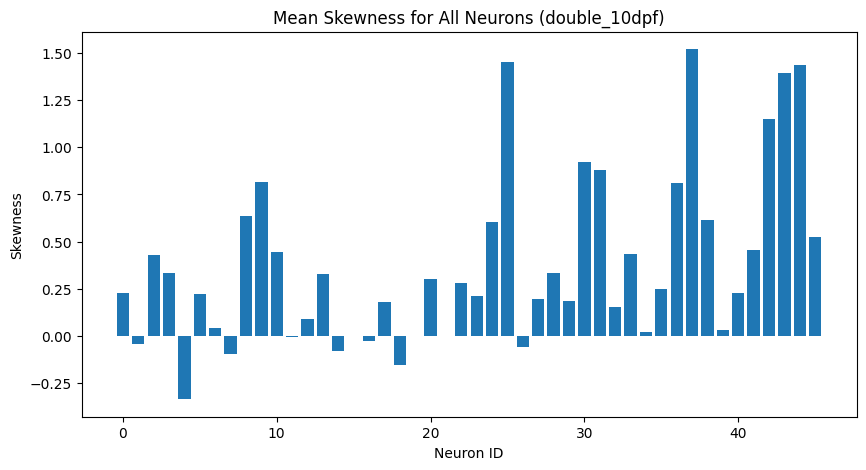

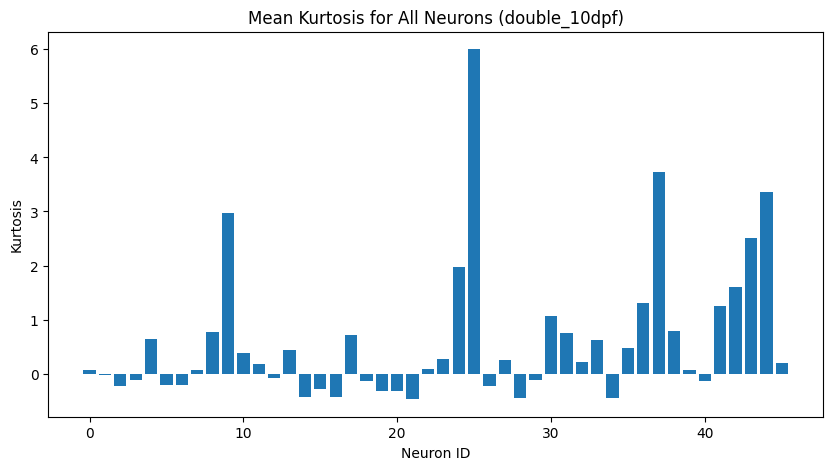

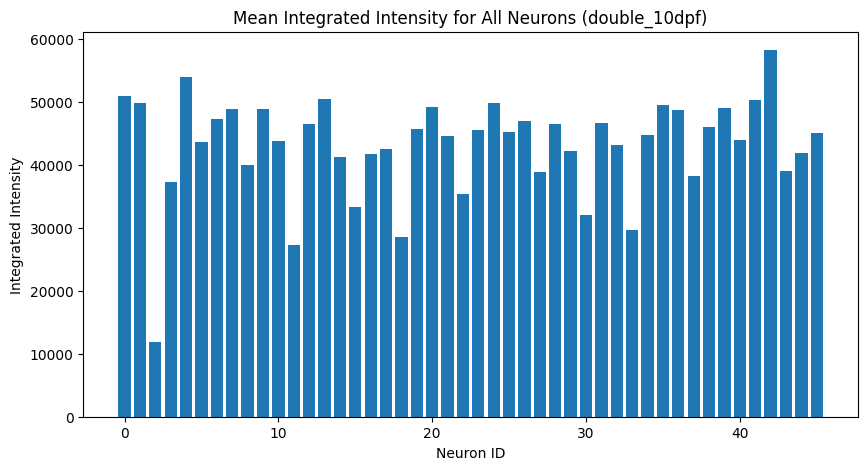

2024-08-17 18:26:52,129 - INFO - Completed plotting of all metrics
2024-08-17 18:26:52,137 - INFO - Starting analysis of calcium transients
2024-08-17 18:26:52,371 - INFO - Completed analysis of calcium transients
2024-08-17 18:26:52,371 - INFO - Visualizing calcium transient features for 10dpf (Double Dose)
2024-08-17 18:26:53,084 - INFO - Saved amplitude visualization to D:\Kofi-TH2\working code output data\amplitude_10dpf (Double Dose).png
2024-08-17 18:26:53,796 - INFO - Saved mean_intensity visualization to D:\Kofi-TH2\working code output data\mean_intensity_10dpf (Double Dose).png
2024-08-17 18:26:54,446 - INFO - Saved std_intensity visualization to D:\Kofi-TH2\working code output data\std_intensity_10dpf (Double Dose).png
2024-08-17 18:26:55,168 - INFO - Saved skewness visualization to D:\Kofi-TH2\working code output data\skewness_10dpf (Double Dose).png
2024-08-17 18:26:55,893 - INFO - Saved kurtosis visualization to D:\Kofi-TH2\working code output data\kurtosis_10dpf (Double D

Analysis Summary:
Total Neurons Analyzed: 61
Neurons with Complete Data: 61
Neurons with Missing Decay Times: 0


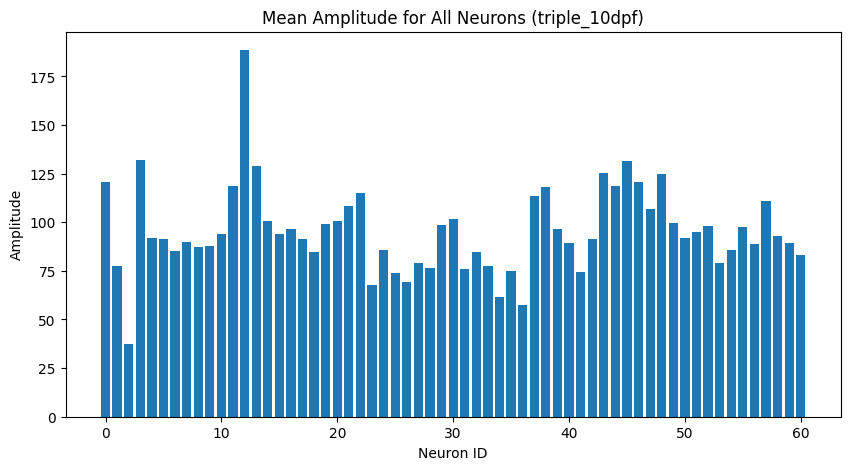

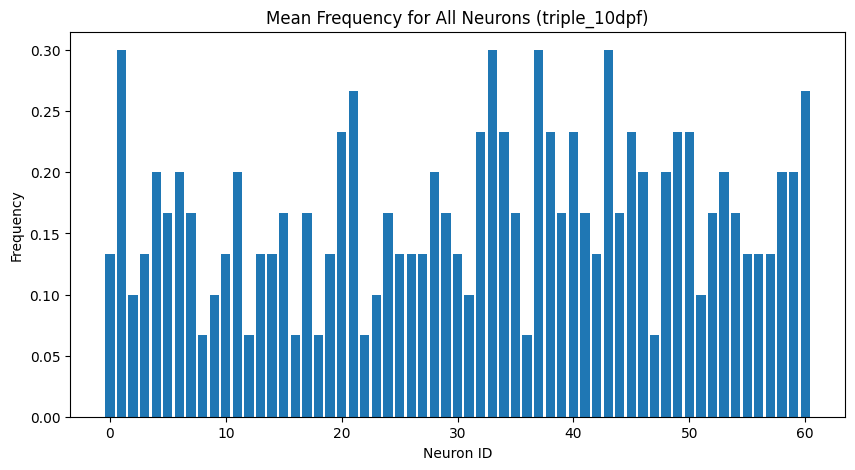

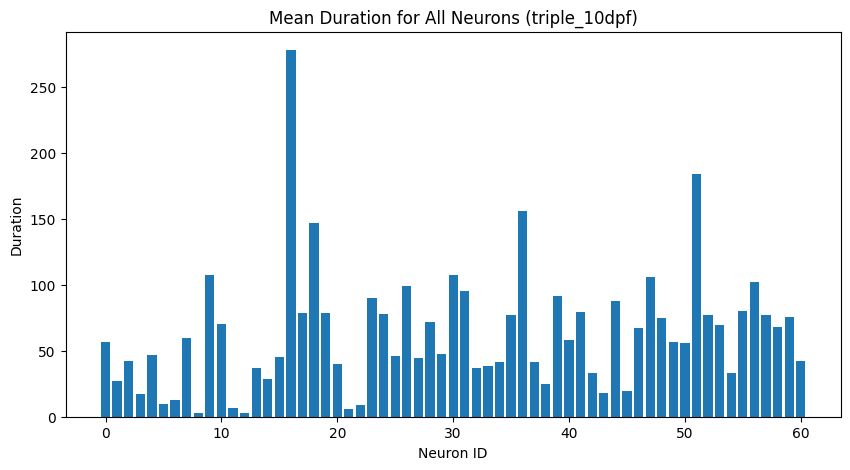

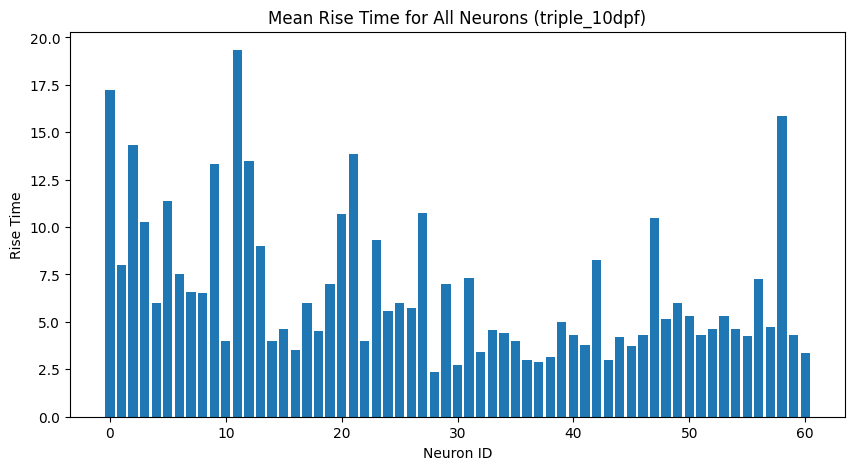

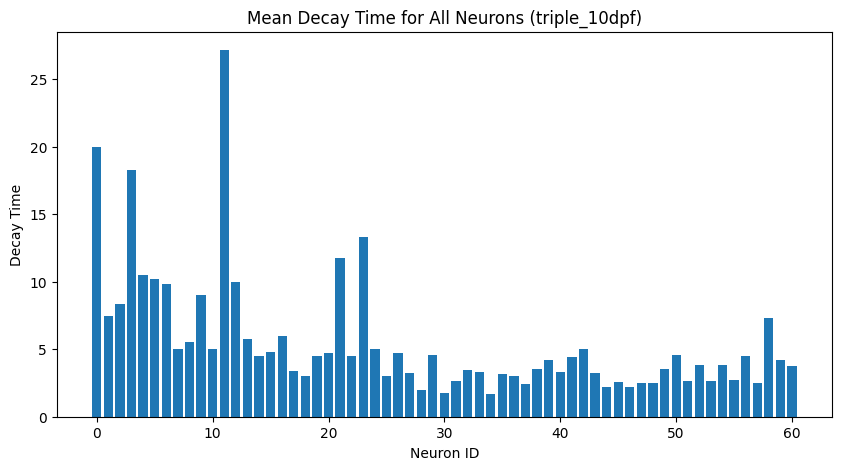

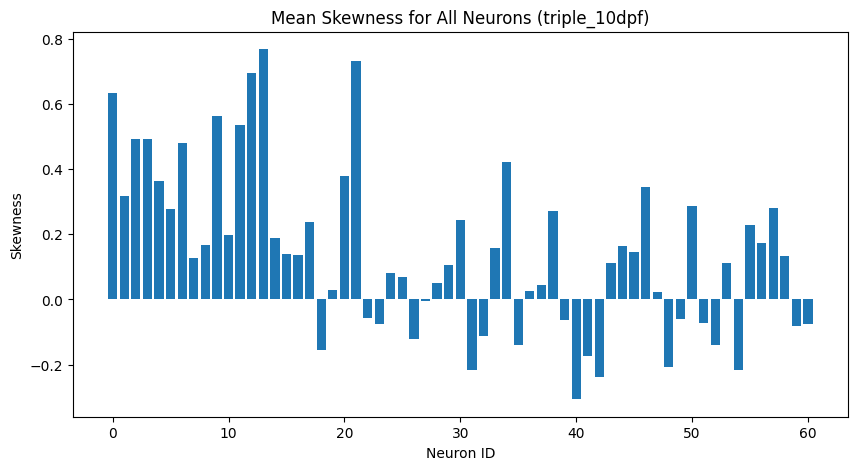

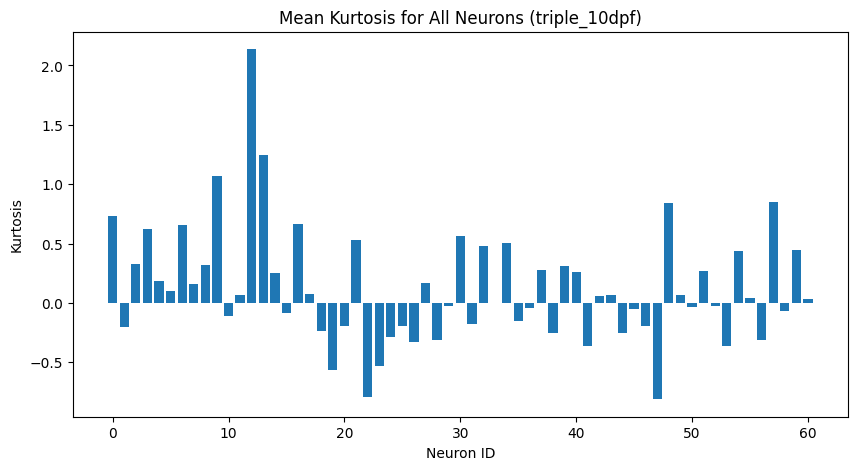

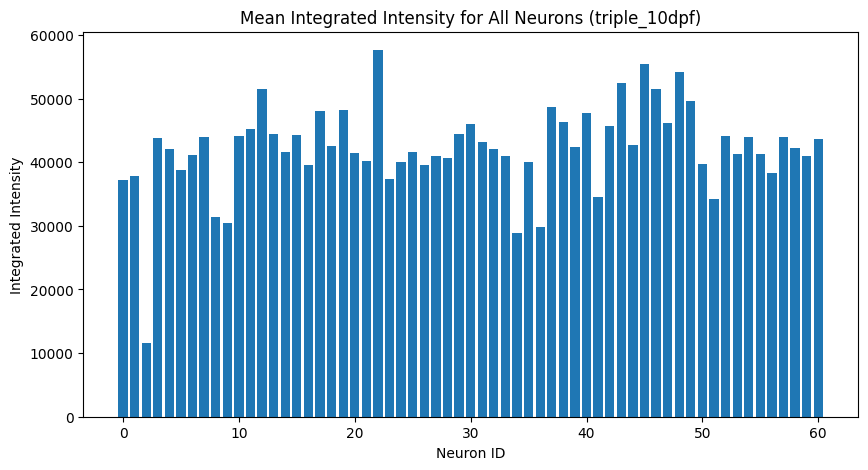

2024-08-17 18:28:06,885 - INFO - Completed plotting of all metrics
2024-08-17 18:28:06,890 - INFO - Starting analysis of calcium transients
2024-08-17 18:28:07,120 - INFO - Completed analysis of calcium transients
2024-08-17 18:28:07,120 - INFO - Visualizing calcium transient features for 10dpf (Triple Dose)
2024-08-17 18:28:07,953 - INFO - Saved amplitude visualization to D:\Kofi-TH2\working code output data\amplitude_10dpf (Triple Dose).png
2024-08-17 18:28:08,705 - INFO - Saved mean_intensity visualization to D:\Kofi-TH2\working code output data\mean_intensity_10dpf (Triple Dose).png
2024-08-17 18:28:09,353 - INFO - Saved std_intensity visualization to D:\Kofi-TH2\working code output data\std_intensity_10dpf (Triple Dose).png
2024-08-17 18:28:10,107 - INFO - Saved skewness visualization to D:\Kofi-TH2\working code output data\skewness_10dpf (Triple Dose).png
2024-08-17 18:28:10,831 - INFO - Saved kurtosis visualization to D:\Kofi-TH2\working code output data\kurtosis_10dpf (Triple D

Analysis Summary:
Total Neurons Analyzed: 651
Neurons with Complete Data: 651
Neurons with Missing Decay Times: 0


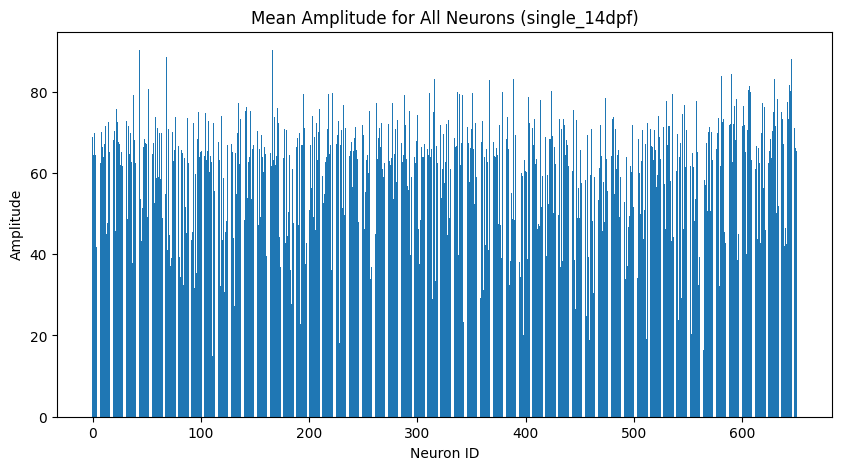

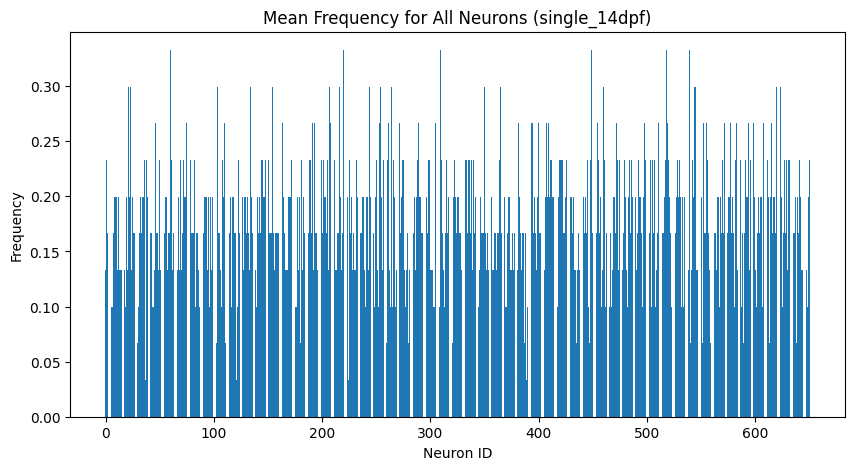

d:\anaconda3\envs\TH2_calcium_dynamics_analysis\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\anaconda3\envs\TH2_calcium_dynamics_analysis\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


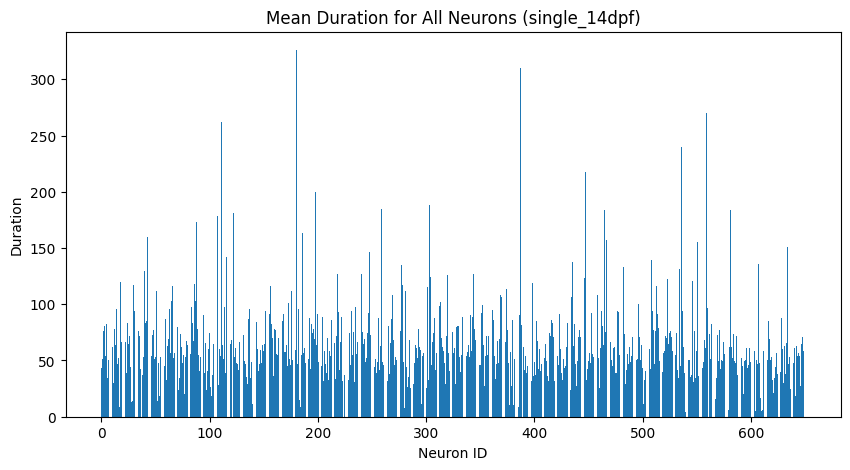

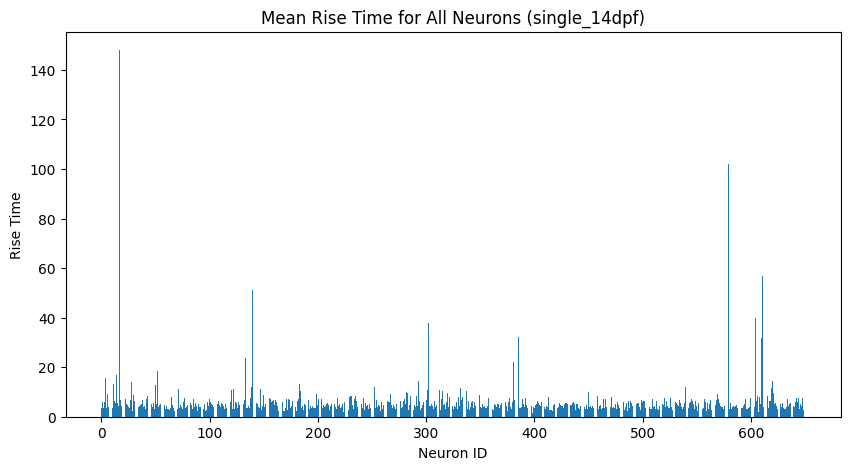

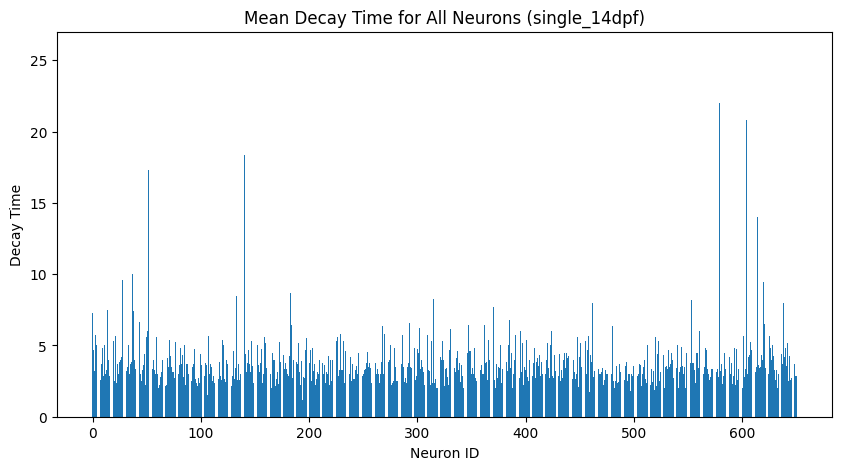

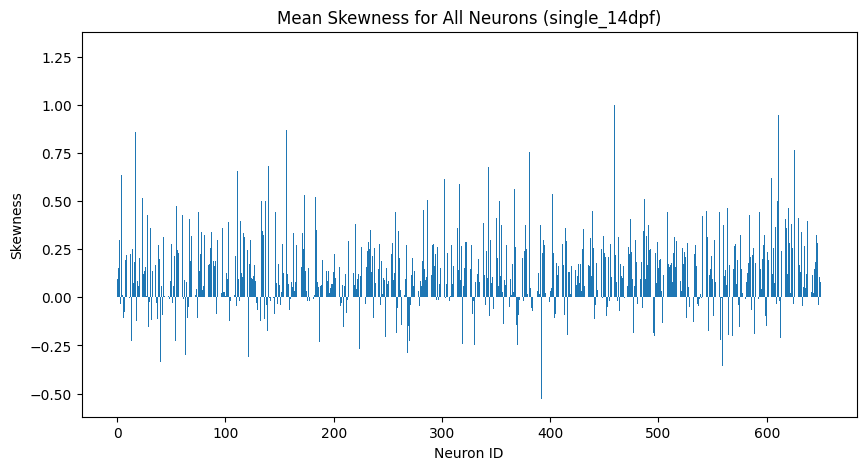

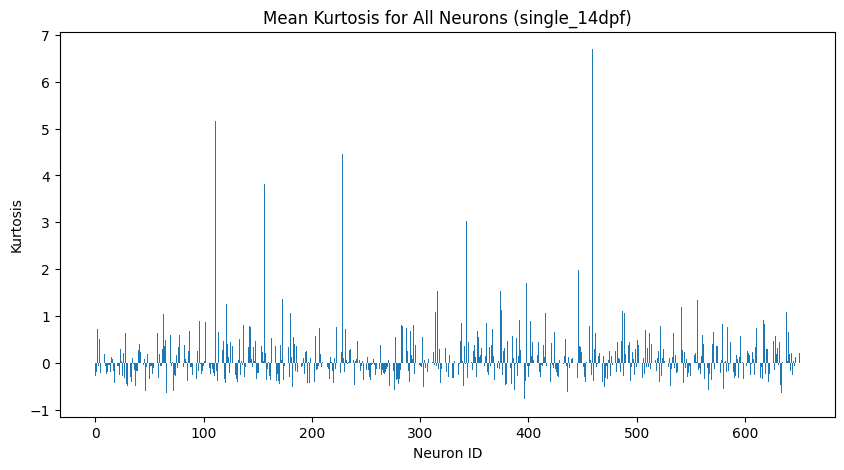

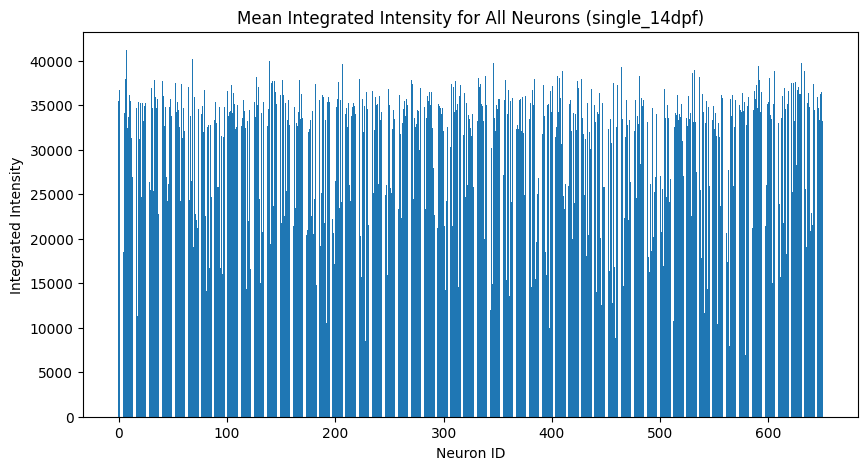

2024-08-17 18:32:39,464 - INFO - Completed plotting of all metrics
2024-08-17 18:32:39,510 - INFO - Starting analysis of calcium transients
2024-08-17 18:32:39,754 - INFO - Completed analysis of calcium transients
2024-08-17 18:32:39,754 - INFO - Visualizing calcium transient features for 14dpf (Single Dose)
2024-08-17 18:32:40,464 - INFO - Saved amplitude visualization to D:\Kofi-TH2\working code output data\amplitude_14dpf (Single Dose).png
2024-08-17 18:32:42,314 - INFO - Saved mean_intensity visualization to D:\Kofi-TH2\working code output data\mean_intensity_14dpf (Single Dose).png
2024-08-17 18:32:43,031 - INFO - Saved std_intensity visualization to D:\Kofi-TH2\working code output data\std_intensity_14dpf (Single Dose).png
2024-08-17 18:32:43,752 - INFO - Saved skewness visualization to D:\Kofi-TH2\working code output data\skewness_14dpf (Single Dose).png
2024-08-17 18:32:44,408 - INFO - Saved kurtosis visualization to D:\Kofi-TH2\working code output data\kurtosis_14dpf (Single D

Analysis Summary:
Total Neurons Analyzed: 298
Neurons with Complete Data: 298
Neurons with Missing Decay Times: 0


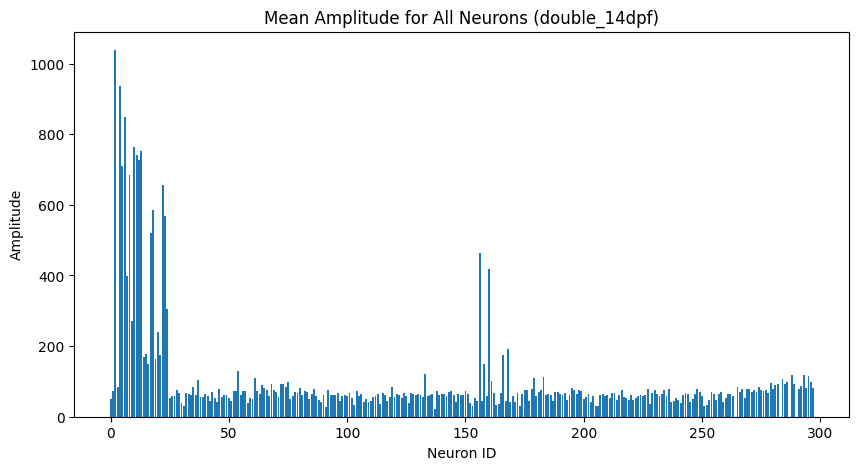

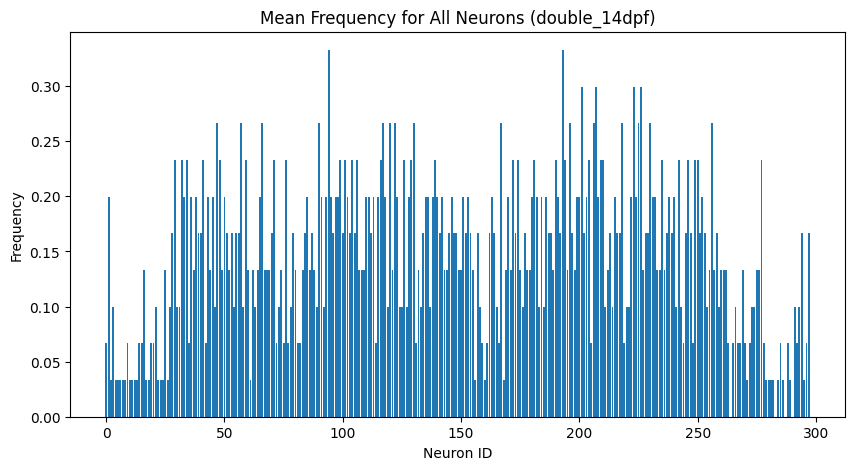

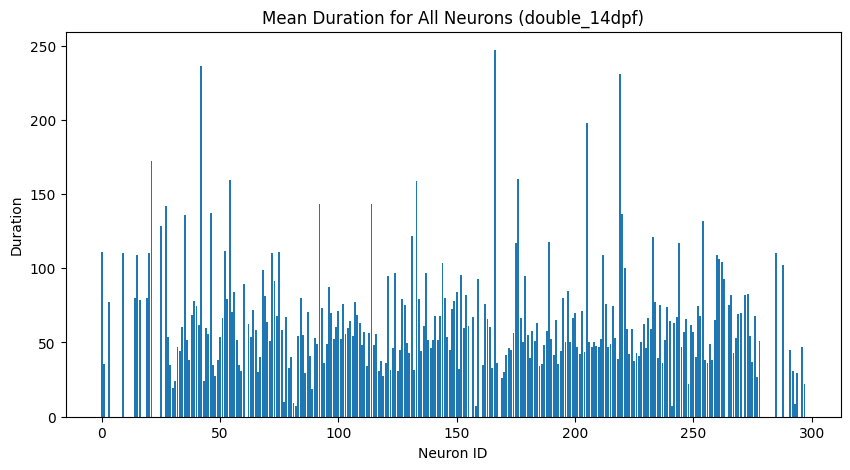

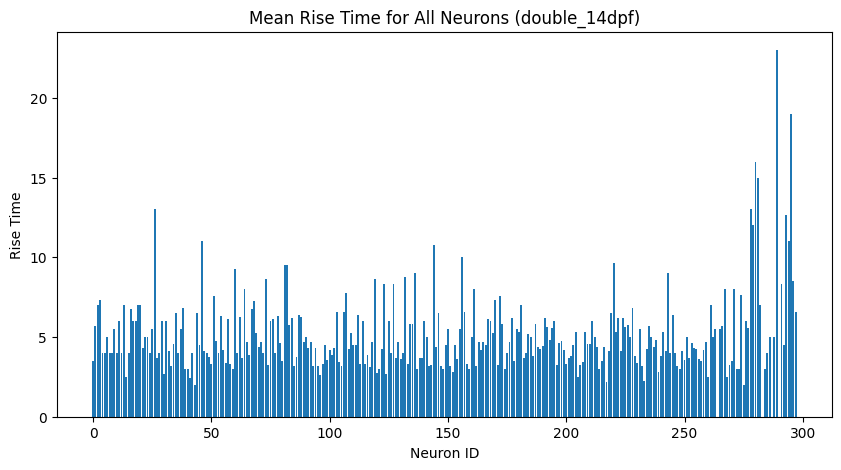

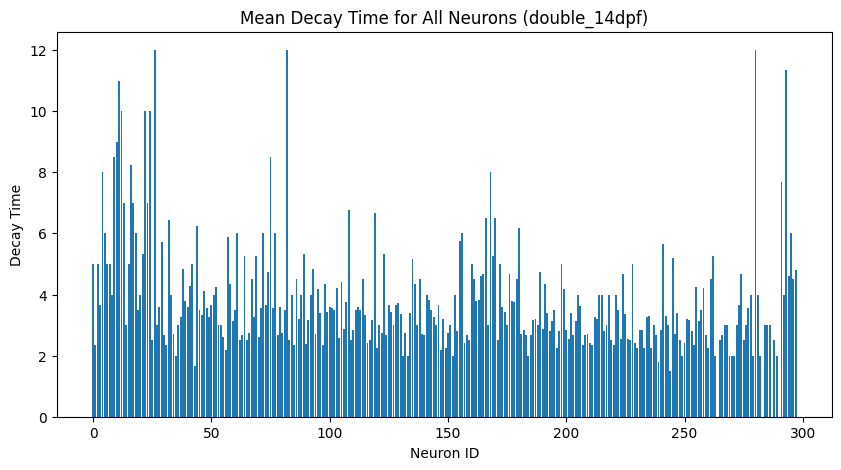

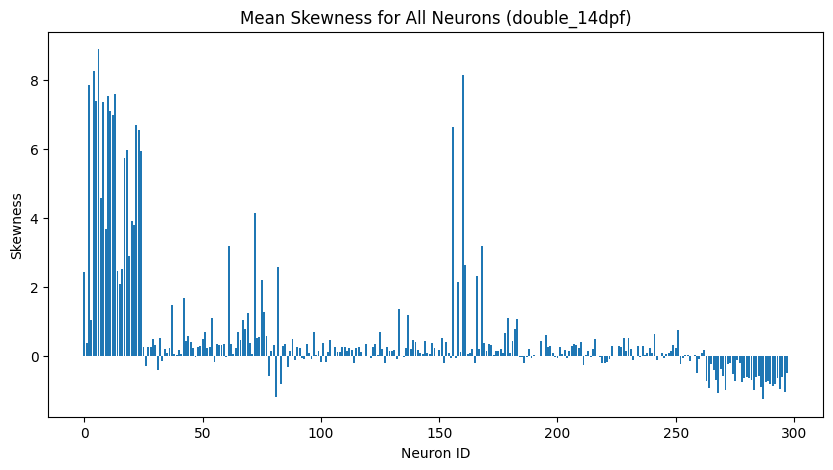

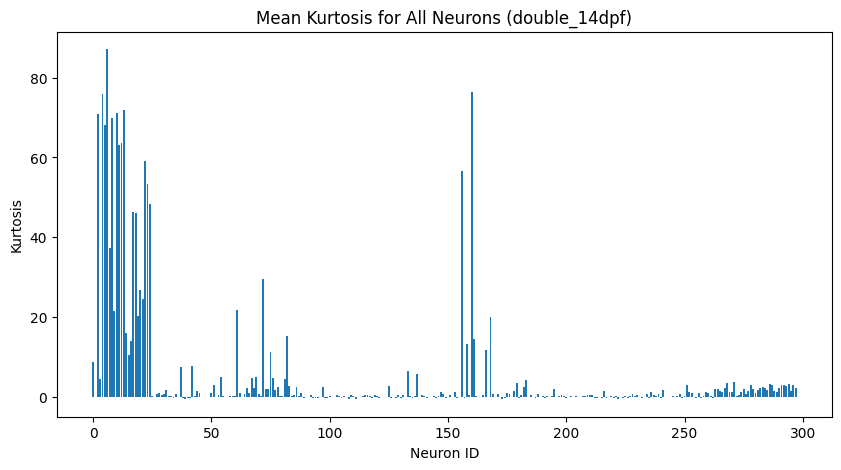

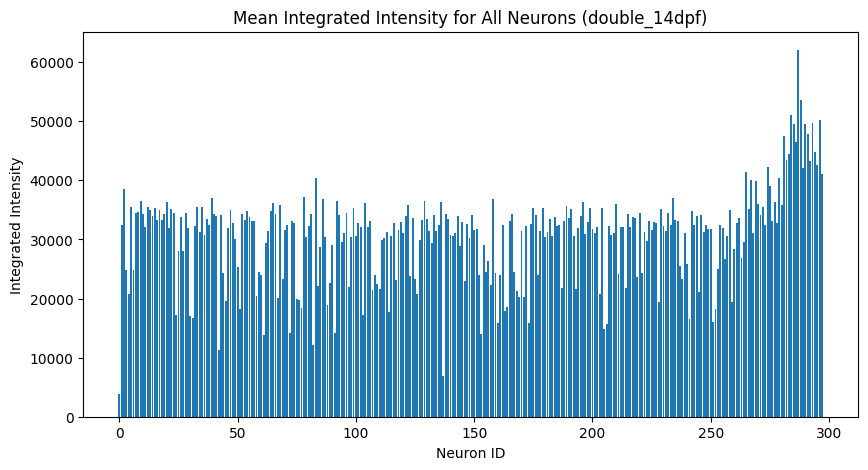

2024-08-17 18:35:16,111 - INFO - Completed plotting of all metrics
2024-08-17 18:35:16,134 - INFO - Starting analysis of calcium transients
2024-08-17 18:35:16,395 - INFO - Completed analysis of calcium transients
2024-08-17 18:35:16,395 - INFO - Visualizing calcium transient features for 14dpf (Double Dose)
2024-08-17 18:35:17,128 - INFO - Saved amplitude visualization to D:\Kofi-TH2\working code output data\amplitude_14dpf (Double Dose).png
2024-08-17 18:35:17,828 - INFO - Saved mean_intensity visualization to D:\Kofi-TH2\working code output data\mean_intensity_14dpf (Double Dose).png
2024-08-17 18:35:18,545 - INFO - Saved std_intensity visualization to D:\Kofi-TH2\working code output data\std_intensity_14dpf (Double Dose).png
2024-08-17 18:35:19,295 - INFO - Saved skewness visualization to D:\Kofi-TH2\working code output data\skewness_14dpf (Double Dose).png
2024-08-17 18:35:19,945 - INFO - Saved kurtosis visualization to D:\Kofi-TH2\working code output data\kurtosis_14dpf (Double D

Analysis Summary:
Total Neurons Analyzed: 1206
Neurons with Complete Data: 1206
Neurons with Missing Decay Times: 0


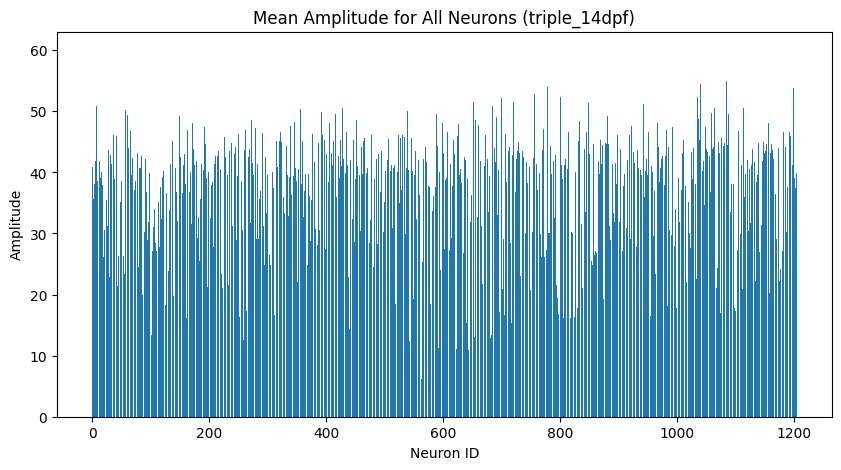

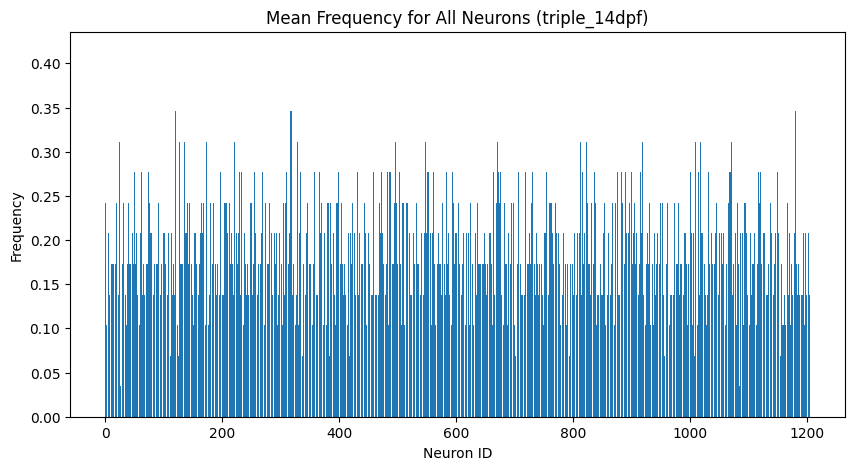

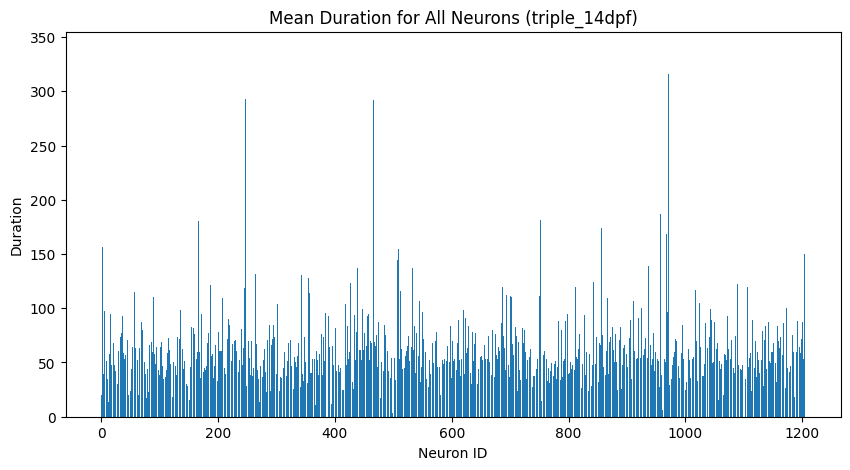

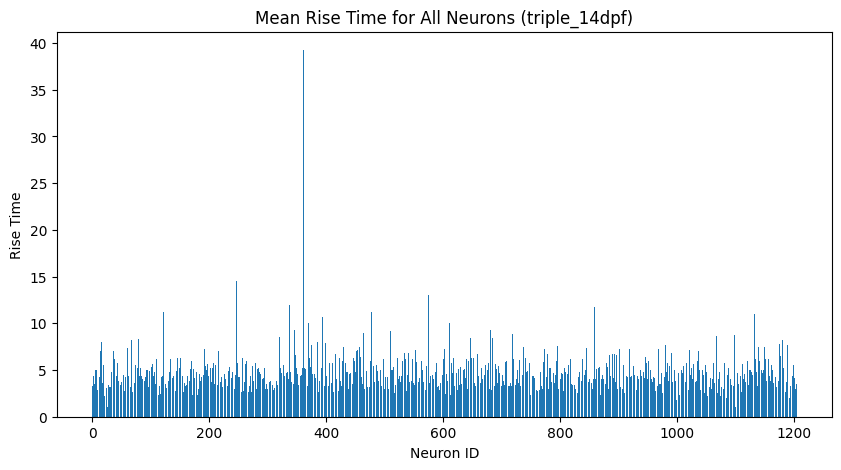

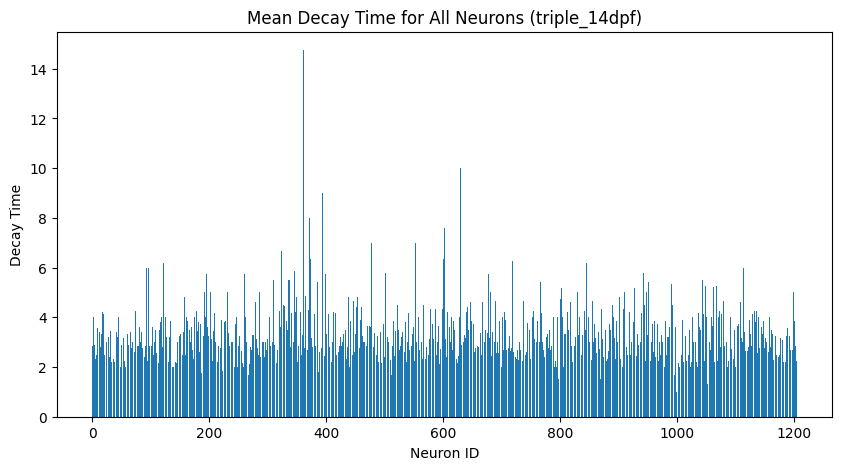

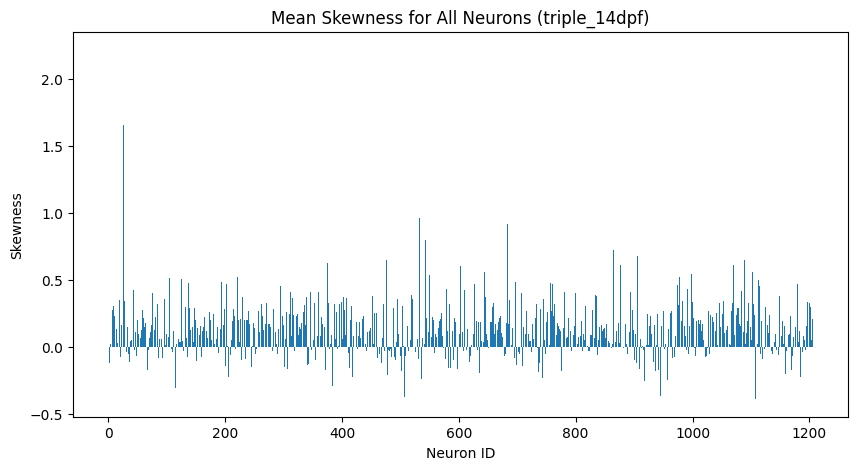

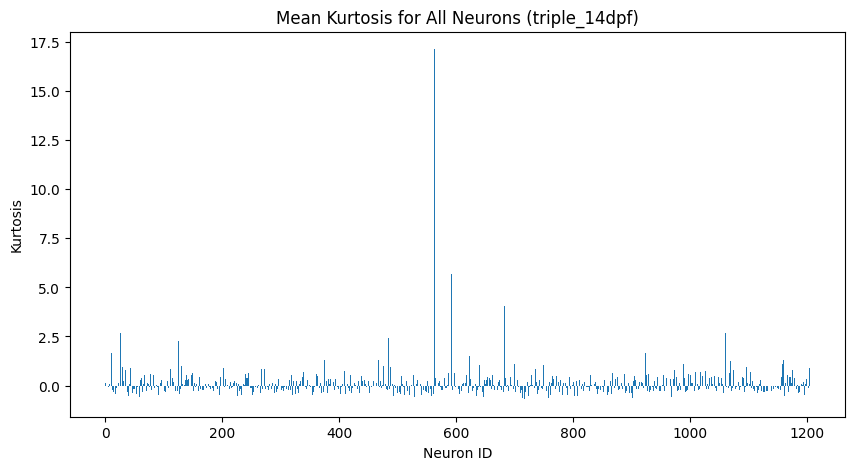

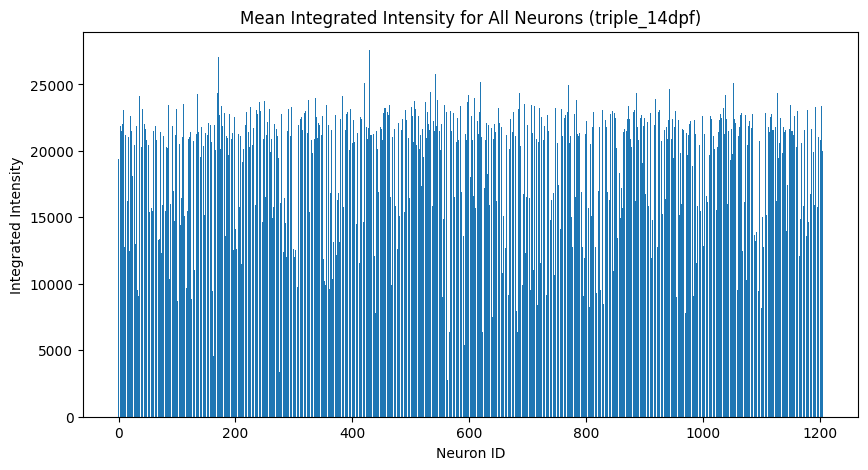

2024-08-17 18:38:17,990 - INFO - Completed plotting of all metrics
2024-08-17 18:38:18,092 - INFO - Starting analysis of calcium transients
2024-08-17 18:38:18,323 - INFO - Completed analysis of calcium transients
2024-08-17 18:38:18,339 - INFO - Visualizing calcium transient features for 14dpf (Triple Dose)
2024-08-17 18:38:19,025 - INFO - Saved amplitude visualization to D:\Kofi-TH2\working code output data\amplitude_14dpf (Triple Dose).png
2024-08-17 18:38:20,991 - INFO - Saved mean_intensity visualization to D:\Kofi-TH2\working code output data\mean_intensity_14dpf (Triple Dose).png
2024-08-17 18:38:21,731 - INFO - Saved std_intensity visualization to D:\Kofi-TH2\working code output data\std_intensity_14dpf (Triple Dose).png
2024-08-17 18:38:22,374 - INFO - Saved skewness visualization to D:\Kofi-TH2\working code output data\skewness_14dpf (Triple Dose).png
2024-08-17 18:38:23,118 - INFO - Saved kurtosis visualization to D:\Kofi-TH2\working code output data\kurtosis_14dpf (Triple D

In [3]:

import numpy as np
import cv2
from scipy.spatial import distance
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.morphology import label
from skimage.measure import regionprops
from scipy.signal import find_peaks, butter, filtfilt
from scipy.ndimage import gaussian_filter
import pywt
import os
import logging
import pandas as pd
import time
from PIL import Image
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.stats import skew, kurtosis

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Hybrid Approach for Nucleus Segmentation and Fluorescent Point Detection

def hybrid_detect_fluorescent_points(image, manual_threshold_value=0.1):
    logging.info("Starting hybrid fluorescent point detection")

    # Step 1: Normalize the image (from Approach 1)
    image_norm = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    # Step 2: Attempt Otsu's thresholding (from Approach 2)
    try:
        otsu_thresh_val = threshold_otsu(image_norm)
        binary_otsu = image_norm > otsu_thresh_val
        logging.info("Otsu's thresholding applied successfully")

    except Exception as e:
        logging.warning(f"Otsu's thresholding failed: {e}")
        binary_otsu = None

    # Step 3: Manual thresholding (from Approach 1) as fallback or secondary step
    _, binary_manual = cv2.threshold(image_norm, manual_threshold_value, 1, cv2.THRESH_BINARY)

    # Step 4: Combine results if both methods were successful
    if binary_otsu is not None:
        binary_combined = np.logical_or(binary_otsu, binary_manual)
    else:
        binary_combined = binary_manual  # If Otsu failed, use manual threshold only

    # Step 5: Post-processing (clear border and label connected components)
    cleared = clear_border(binary_combined)
    label_image = label(cleared)

    logging.info("Completed hybrid fluorescent point detection")
    return label_image

# Function to load and process TIFF data in batches
def load_and_preprocess_tiff_in_batches(file_path, batch_size=10):
    logging.info(f"Checking file: {file_path}")
    if os.path.exists(file_path):
        try:
            tiff_image = Image.open(file_path)
            frames = []
            batch_results = []

            for i in range(tiff_image.n_frames):
                tiff_image.seek(i)
                frame = np.array(tiff_image)
                frames.append(frame)
                
                # Process in batches
                if len(frames) == batch_size:
                    batch_result = process_batch(np.stack(frames, axis=0))
                    batch_results.append(batch_result)
                    frames = []  # Clear memory after processing each batch

            # Process any remaining frames
            if frames:
                batch_result = process_batch(np.stack(frames, axis=0))
                batch_results.append(batch_result)
                
            tiff_image.close()

            logging.info(f"Successfully processed {len(batch_results)} batches from {file_path}")
            return np.concatenate(batch_results, axis=0)

        except Exception as e:
            logging.error(f"Error loading TIFF data from {file_path}: {e}")
            return None
    else:
        logging.error(f'TIFF file not found: {file_path}')
        return None

def process_batch(frames):
    # Perform motion correction on the batch of frames
    corrected_frames = motion_correction(frames)
    return corrected_frames

# Function to perform motion correction on 3D data with parallel processing
def motion_correction(frames):
    logging.info("Starting motion correction")
    ref_frame = frames[0].astype(np.float32)
    
    def correct_frame(frame):
        frame = frame.astype(np.float32)
        res = cv2.matchTemplate(frame, ref_frame, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(res)
        corrected_frame = np.roll(frame, -max_loc[0], axis=1)
        corrected_frame = np.roll(corrected_frame, -max_loc[1], axis=0)
        return corrected_frame
    
    with ThreadPoolExecutor() as executor:
        corrected_frames = list(executor.map(correct_frame, frames))
    
    logging.info("Completed motion correction")
    return np.stack(corrected_frames, axis=0)

# Function to extract fluorescent intensities for detected points
def extract_fluorescent_intensities(label_image, frames):
    logging.info("Starting extraction of fluorescent intensities")
    intensities = {}
    for region in measure.regionprops(label_image):
        coords = region.coords
        neuron_id = region.label
        neuron_intensity = []

        if coords.shape[1] == 3:  # Handling 3D coordinates
            for frame in frames:
                neuron_intensity.append(np.mean([frame[z, y, x] for z, y, x in coords]))
        elif coords.shape[1] == 2:  # Handling 2D coordinates (Z assumed to be absent)
            for frame in frames:
                neuron_intensity.append(np.mean([frame[y, x] for y, x in coords]))

        intensities[neuron_id] = neuron_intensity
    logging.info("Completed extraction of fluorescent intensities")
    return intensities

# Function to match neurons based on 3D centroids
def match_neurons(control_fluorescent_label_image, treated_fluorescent_label_image):
    logging.info("Starting neuron matching based on 3D centroids")
    control_centroids = np.array([np.mean(region.coords, axis=0) for region in measure.regionprops(control_fluorescent_label_image)])
    treated_centroids = np.array([np.mean(region.coords, axis=0) for region in measure.regionprops(treated_fluorescent_label_image)])
    
    matched_indices = []
    for control_index, control_centroid in enumerate(control_centroids):
        distances = distance.cdist([control_centroid], treated_centroids, 'euclidean')
        matched_index = np.argmin(distances)
        
        # Check if both control and treated indices exist
        if control_index in control_fluorescent_label_image and matched_index in treated_fluorescent_label_image:
            matched_indices.append((control_index, matched_index))
    
    logging.info("Completed neuron matching")
    return matched_indices

# Function to visualize calcium dynamics in 3D
def visualize_calcium_3d(intensities, time_points, output_path, neuron_id, group_label):
    logging.info(f"Starting 3D visualization for neuron {neuron_id} in {group_label}")
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(time_points, intensities, zs=neuron_id, zdir='y', label=f'Neuron {neuron_id}')
    ax.set_title(f'Calcium Dynamics for Neuron {neuron_id} ({group_label})')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron ID')
    ax.set_zlabel('Intensity')
    plt.legend()
    plt.savefig(output_path)
    plt.close()
    logging.info(f"Saved 3D visualization to {output_path}")


# Function to generate a time-lapse video
def generate_time_lapse_video(frames, output_path, fps=16.67):
    logging.info(f"Starting time-lapse video generation for {output_path}")
    if len(frames[0].shape) == 2:  # 2D frames (grayscale)
        height, width = frames[0].shape
        is_color = False
    elif len(frames[0].shape) == 3:  # 3D frames (assuming last dimension is color channel)
        height, width = frames[0].shape[1], frames[0].shape[2]
        is_color = True
    else:
        raise ValueError("Unexpected frame dimensions")

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        if is_color:
            if frame.dtype != np.uint8:
                frame = cv2.convertScaleAbs(frame)
            video.write(frame)
        else:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            if frame_rgb.dtype != np.uint8:
                frame_rgb = cv2.convertScaleAbs(frame_rgb)
            video.write(frame_rgb)

    video.release()
    logging.info(f"Completed time-lapse video generation for {output_path}")

# Function to calculate Signal-to-Noise Ratio (SNR)
def calculate_snr(signal, noise):
    logging.info("Calculating SNR")
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Function to calculate Root Mean Square Error (RMSE)
def calculate_rmse(predicted, actual):
    logging.info("Calculating RMSE")
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    return rmse

# ALS baseline correction function
def baseline_als(y, lam=1e6, p=0.01, niter=10):
    logging.info("Starting ALS baseline correction")
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    W = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(W, 0, L, L)
        Z = spsolve(W + lam * D.dot(D.T), W * y)
        W = p * (y > Z) + (1 - p) * (y < Z)
    logging.info("Completed ALS baseline correction")
    return Z

# Preprocessing function using different filters
def preprocess_signal(signal):
    logging.info("Starting signal preprocessing")
    # ALS Baseline Correction
    baseline = baseline_als(signal)
    detrended_signal = signal - baseline

    # Gaussian Filter
    gaussian_filtered = gaussian_filter(detrended_signal, sigma=1)
    
    logging.info("Completed signal preprocessing")
    return gaussian_filtered

# Function to calculate calcium transients
def calculate_calcium_transients(intensities):
    logging.info("Starting calcium transient calculations")
    transients = {}
    snr_values = {}
    rmse_values = {}
    for neuron_id, intensity in intensities.items():
        intensity = np.array(intensity)
        filtered_signal = preprocess_signal(intensity)

        transients[neuron_id] = {}
        snr_values[neuron_id] = {}
        rmse_values[neuron_id] = {}
        
        smoothed_intensity = filtered_signal[:400]  # Focus on frames 0 to 400

        # Calculate the baseline and standard deviation
        baseline_mean = np.mean(smoothed_intensity)
        baseline_std = np.std(smoothed_intensity)

        # Set the peak threshold as a multiple of the standard deviation
        peak_threshold = baseline_mean + 2 * baseline_std

        peaks, _ = find_peaks(smoothed_intensity, height=peak_threshold)
        amplitudes = smoothed_intensity[peaks] - baseline_mean
        durations = np.diff(peaks)
        frequency = len(peaks) / (len(intensity) / 16.67)  # Using fps of 16.67
        rise_times = []
        decay_times = []

        for peak in peaks:
            baseline = np.mean(smoothed_intensity[:peak])
            rise_indices = np.where(smoothed_intensity[:peak] <= baseline)[0]
            if len(rise_indices) > 0:
                rise_start = rise_indices[-1]
            else:
                rise_start = 0
            rise_time = peak - rise_start
            rise_times.append(rise_time)

            # Decay time calculation improvements
            decay_indices = np.where(smoothed_intensity[peak:] <= baseline + (baseline_std * 0.5))[0]
            if len(decay_indices) > 0:
                decay_end = decay_indices[0] + peak
                decay_time = decay_end - peak
            else:
                decay_time = len(smoothed_intensity) - peak
            decay_times.append(decay_time)

        transients[neuron_id]['ALS_Gaussian'] = {
            'Amplitude': amplitudes,
            'Frequency': frequency,
            'Duration': durations,
            'Rise Time': rise_times,
            'Decay Time': decay_times,
            'Smoothed Intensity': smoothed_intensity,
            'Skewness': skew(smoothed_intensity),
            'Kurtosis': kurtosis(smoothed_intensity),
            'Integrated Intensity': np.sum(smoothed_intensity)
        }

        # Calculate SNR and RMSE
        noise = smoothed_intensity - baseline_mean
        snr_values[neuron_id]['ALS_Gaussian'] = calculate_snr(smoothed_intensity, noise)
        rmse_values[neuron_id]['ALS_Gaussian'] = calculate_rmse(smoothed_intensity, intensity[:400])

    logging.info("Completed calcium transient calculations")
    return transients, snr_values, rmse_values


def visualize_calcium_transient_features(control_features, treated_features, title_suffix, output_dir, group_labels):
    logging.info(f"Visualizing calcium transient features for {title_suffix}")
    
    features = ['amplitude', 'mean_intensity', 'std_intensity', 'skewness', 'kurtosis', 'integrated_intensity']
    
    for feature in features:
        plt.figure(figsize=(10, 5))
        plt.bar(control_features.index, control_features[feature], alpha=0.7, label=f'{group_labels["control"]} - Control', color='blue')
        plt.bar(treated_features.index, treated_features[feature], alpha=0.7, label=f'{group_labels["treated"]} - Treated', color='red')
        plt.title(f'{feature.title()} Comparison - {title_suffix}')
        plt.xlabel('Neuron ID')
        plt.ylabel(feature.title())
        plt.legend()
        plt_path = os.path.join(output_dir, f'{feature}_{title_suffix}.png')
        plt.savefig(plt_path)
        plt.close()
        logging.info(f"Saved {feature} visualization to {plt_path}")


# Function to analyze calcium transients with additional features
def analyze_calcium_transients(df):
    """
    Analyzes calcium transients in the given DataFrame.
    Args:
    - df: A DataFrame where each column represents the signal for a neuron over time.

    Returns:
    - A DataFrame containing features such as amplitude, rise time, decay time, etc., for each neuron.
    """
    logging.info("Starting analysis of calcium transients")
    
    features = pd.DataFrame(index=df.columns)
    
    features['amplitude'] = df.max() - df.min()
    features['mean_intensity'] = df.mean()
    features['std_intensity'] = df.std()
    features['skewness'] = df.apply(skew, axis=0)
    features['kurtosis'] = df.apply(kurtosis, axis=0)
    features['integrated_intensity'] = df.sum()
    
    # More complex features can be added here as needed
    logging.info("Completed analysis of calcium transients")
    
    return features

# Function to summarize analysis results
def summarize_analysis(transients):
    logging.info("Starting analysis summary")
    summary = {
        'Total Neurons': len(transients),
        'Neurons with Complete Data': 0,
        'Neurons with Missing Decay Times': 0
    }
    for neuron_id, data in transients.items():
        decay_times = data['ALS_Gaussian']['Decay Time']
        if np.isnan(decay_times).any():
            summary['Neurons with Missing Decay Times'] += 1
        else:
            summary['Neurons with Complete Data'] += 1
    
    print("Analysis Summary:")
    print(f"Total Neurons Analyzed: {summary['Total Neurons']}")
    print(f"Neurons with Complete Data: {summary['Neurons with Complete Data']}")
    print(f"Neurons with Missing Decay Times: {summary['Neurons with Missing Decay Times']}")

    logging.info("Completed analysis summary")
    return summary

# Function to plot calcium transients metrics for all neurons
def plot_all_metrics(transients, group_label):
    logging.info("Starting plotting of all metrics")
    metrics = ['Amplitude', 'Frequency', 'Duration', 'Rise Time', 'Decay Time', 'Skewness', 'Kurtosis', 'Integrated Intensity']
    
    for metric in metrics:
        values = [np.mean(data['ALS_Gaussian'][metric]) for _, data in transients.items() if metric in data['ALS_Gaussian']]
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(values)), values)
        plt.title(f'Mean {metric} for All Neurons ({group_label})')
        plt.xlabel('Neuron ID')
        plt.ylabel(metric)
        plt.show()
    logging.info("Completed plotting of all metrics")

    
    
#  Function to summarize analysis results and generate a detailed comparison between control and treated groups    
def generate_summary(control_features, treated_features, time_point, dose_type):
    summary = f"Summary for {time_point} - {dose_type} Dose\n"
    summary += "----------------------------------------\n"
    summary += f"Number of neurons analyzed in control: {len(control_features)}\n"
    summary += f"Number of neurons analyzed in treated: {len(treated_features)}\n\n"
    
    metrics = ['amplitude', 'frequency', 'integrated_intensity', 'decay_time', 'rise_time', 'duration']
    
    for metric in metrics:
        if metric in control_features.columns and metric in treated_features.columns:
            control_mean = control_features[metric].mean()
            treated_mean = treated_features[metric].mean()
            control_std = control_features[metric].std()
            treated_std = treated_features[metric].std()

            summary += f"Metric: {metric.replace('_', ' ').title()}\n"
            summary += f"Control Mean: {control_mean:.2f} ± {control_std:.2f}\n"
            summary += f"Treated Mean: {treated_mean:.2f} ± {treated_std:.2f}\n"
            summary += f"Difference (Treated - Control): {treated_mean - control_mean:.2f}\n"
            summary += "----------------------------------------\n"
        else:
            summary += f"Metric: {metric.replace('_', ' ').title()}\n"
            summary += "Data not available for comparison\n"
            summary += "----------------------------------------\n"

    return summary
    

# Updated `main` function to integrate new features with lazy loading and batch processing

def main():
    logging.info("Starting main processing loop")
    base_dir = r"D:\Kofi-TH2\TIF data for final analysis"
    control_paths = {
        '3dpf': os.path.join(base_dir, 'control', '3dpf_baseline_control_larvae-14.tif'),
        '4dpf': os.path.join(base_dir, 'control', '4dpf_control.tif'),
        '7dpf': os.path.join(base_dir, 'control', '7dpf_control.tif'),
        '10dpf': os.path.join(base_dir, 'control', '10dpf_control_lavrae-14.tif'),
        '14dpf': os.path.join(base_dir, 'control', '14dpf_control_larvae-14.tif')
    }

    treated_paths = {
        'single_3dpf': os.path.join(base_dir, 'single', '3dpf_single_dose_1hr_post_treatment.tif'),
        'single_10dpf': os.path.join(base_dir, 'single', '10dpf_singleD_treatment_larvae-01.tif'),
        'single_14dpf': os.path.join(base_dir, 'single', '14dpf_singleD_treatment_larvae-01.tif'),
        'double_4dpf': os.path.join(base_dir, 'double', '4dpf_doubleD_1hr_post_treatment_larvae-03.tif'),
        'double_10dpf': os.path.join(base_dir, 'double', '10dpf_doubleD_treatment_larvae-03.tif'),
        'double_14dpf': os.path.join(base_dir, 'double', '14dpf_doubleD_treatment_larvae-03.tif'),
        'triple_7dpf': os.path.join(base_dir, 'triple', '7dpf_tripleD_1hr_post_treatment_larvae-05.tif'),
        'triple_10dpf': os.path.join(base_dir, 'triple', '10dpf_tripleD_treatment_larvae-05.tif'),
        'triple_14dpf': os.path.join(base_dir, 'triple', '14dpf_tripleD_treatment_larvae-05.tif')
    }

    output_dir = r"D:\Kofi-TH2\working code output data"
    os.makedirs(output_dir, exist_ok=True)

    results = {}

    for time_point, control_path in control_paths.items():
        logging.info(f"Processing control data for {time_point}")
        control_frames = load_and_preprocess_tiff_in_batches(control_path)
        if control_frames is not None:
            logging.info(f'Loaded control TIFF data for {time_point}: {control_frames.shape[0]} frames')

            # Perform motion correction on the control frames
            control_frames = motion_correction(control_frames)
            control_fluorescent_label_image = hybrid_detect_fluorescent_points(control_frames[0])
            control_intensities = extract_fluorescent_intensities(control_fluorescent_label_image, control_frames)

            # Preprocess signals (if applicable)
            for neuron_id, signal in control_intensities.items():
                control_intensities[neuron_id] = preprocess_signal(np.array(signal))
                
            # Analyze the control data to obtain control_features 
            control_features = analyze_calcium_transients(pd.DataFrame(control_intensities).T)   

            # Define treated_keys based on the time point
            treated_keys = [time_point]
            if time_point in ['7dpf', '10dpf', '14dpf']:
                treated_keys = [f'single_{time_point}', f'double_{time_point}', f'triple_{time_point}']

            for treated_key in treated_keys:
                logging.info(f"Processing treated data for {treated_key}")
                treated_path = treated_paths.get(treated_key)
                if treated_path and os.path.exists(treated_path):
                    treated_frames = load_and_preprocess_tiff_in_batches(treated_path)
                    if treated_frames is not None:
                        logging.info(f'Loaded treated TIFF data for {treated_key}: {treated_frames.shape[0]} frames')

                        treated_fluorescent_label_image = hybrid_detect_fluorescent_points(treated_frames[0])
                        treated_intensities = extract_fluorescent_intensities(treated_fluorescent_label_image, treated_frames)
                        matched_indices = match_neurons(control_fluorescent_label_image, treated_fluorescent_label_image)

                        for control_id, treated_id in matched_indices:
                            if treated_id in treated_intensities:
                                time_points = np.arange(0, len(treated_frames)) * (1000 / 16.67)
                                output_path = os.path.join(output_dir, f'3d_visualization_{treated_key}_neuron_{treated_id}.png')
                                visualize_calcium_3d(treated_intensities[treated_id], time_points, output_path, treated_id, group_label=treated_key)

                        # Calculate and analyze calcium transients
                        transients, snr_values, rmse_values = calculate_calcium_transients(treated_intensities)

                        # Summarize analysis
                        summarize_analysis(transients)

                        # Plot metrics for all neurons
                        plot_all_metrics(transients, group_label=treated_key)

                        # Visualize and summarize the calcium transient features
                        treated_features = analyze_calcium_transients(pd.DataFrame(treated_intensities).T)
                        title_suffix = f'{time_point} ({treated_key.split("_")[0].title()} Dose)'
                        group_labels = {"control": f'{time_point} Control', "treated": treated_key.split("_")[0].title()}
                        visualize_calcium_transient_features(control_features, treated_features, title_suffix, output_dir, group_labels)
                        summary_text = generate_summary(control_features, treated_features, time_point, treated_key.split("_")[0].title())
                        with open(os.path.join(output_dir, f'summary_{treated_key}.txt'), 'w') as summary_file:
                            summary_file.write(summary_text)

    logging.info("Completed main processing loop")


if __name__ == "__main__":
    main()